# Exploration of Training Intersections and parking
Import libraries

In [1]:
import sys
sys.path.append('../')
from common import get_train, get_parking, feat_eng, get_test, add_street_sections
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### import data

In [2]:
test_df = get_test()
train_df = get_train()
train_df = feat_eng(train_df)

Time it took: 0.1002049446105957
Time it took: 0.12837600708007812
adding additional features to test and/or train ...

loading parking data 1.7M
loading address data 30K
calculating closest joins
merging
complete
fixing neighborhood string formatting
merging in neighborhood information
Time it took: 0.6107661724090576


#### Loading parking data

In [3]:
parking_df = get_parking()
#parking_df.info()

loading cached copy
Time it took: 2.4426329135894775


In [4]:
parking_df.shape

(1761328, 13)

In [33]:
def get_unique_coords(df, lat_field, lon_field):
    """
    Takes in a dataframe and extract unique fields for plotting.
    Uses dataframe group by to reduce the number of rows that need to
    be plotted, returns the lat and lon fields
    """
    unique = df.groupby([lat_field, lon_field]).size().reset_index()
    lat, lon= unique[lat_field].values, unique[lon_field].values
    return lat, lon


def plot_street(STREET, train_df, parking_df):
    """
    Overlays the different datasets on a 2D map for matplotlib
    """
    train_df['STREET'] = train_df['Street'].map(lambda x : x.upper())
    parking_df['STREET'] = parking_df['road'].map(lambda x : x.upper() if x is not None else x)

    kearny_t= train_df[train_df['STREET']==STREET]
    kearny_p = parking_df[parking_df['STREET']==STREET]
    
    latF, lonF = get_unique_coords(kearny_t, 'From_lat', 'From_long')
    latT, lonT = get_unique_coords(kearny_t, 'To_lat', 'To_long')
    latp, lonp = get_unique_coords(kearny_p, 'lat', 'lon')
    
    
    
    plt.figure(figsize=(7,7))
    plt.title('STREET : %s' % STREET)
    plt.scatter(latp, lonp, c='g', alpha = 0.5)
    plt.scatter(latF, lonF, c='b', alpha=0.5)
    plt.scatter(latT, lonT, c='black', alpha = 0.5)


def add_street_sections(train_df, test_df=None):
    
    train_streets = list(train_df['Street'].unique())
    train_streets = [s.upper() for s in train_streets]
    
    parking_df = get_parking()
    parking_street = list(parking_df['road'].unique())
    parking_street = [s.upper() for s in parking_street if s is not None]
    
    
    print('Identifying key streets...')
    # upper case streets for joining
    train_df['STREET'] = train_df['Street'].map(lambda x : x.upper())
    parking_df['STREET'] = parking_df['road'].map(lambda x : x.upper() if x is not None else x)

    print('Filtering down the parking data ...')
    # down filter to only training streets
    parking_sm_df = parking_df[parking_df['STREET'].isin(train_streets)]
    parking_sm_df.shape
    
    VERT_STREET = ['MISSION STREET', 'PINE STREET', '2ND STREET', 'BRYANT STREET', 
               'POST STREET', 'WASHINGTON STREET', 'JACKSON STREET', 'BUSH STREET', 
               'GEARY STREET', 'GROVE STREET', 'SUTTER STREET', 'COLUMBUS AVENUNE']
    
    print('measuring parking coords within FROM TO bounds ...')
    dist_parking = parking_sm_df.groupby(['lat','lon','STREET']).size().reset_index()
    dist_tr = train_df.groupby(['From_lat','From_long','To_lat','To_long','STREET']).size().reset_index()
    dist_tr['STR_SEC'] = dist_tr.index

    for latf, lonf, latt,lont, street, ct, id_ in dist_tr.values:
        min_lat = min(latf, latt)
        max_lat = max(latf, latt)
        min_lon = min(lonf, lont)
        max_lon = max(lonf, lont)

        if street in VERT_STREET:
            dist_parking.loc[(dist_parking['STREET'] == street) & (dist_parking['lon'] < max_lon) & (dist_parking['lon'] > min_lon),"STR_SEC" ] = id_ 
        else:
            dist_parking.loc[(dist_parking['STREET'] == street) & (dist_parking['lat'] < max_lat) & (dist_parking['lat'] > min_lat) ,"STR_SEC" ] = id_ 

    print('Adding street section ids to train and parking ...')
    rejoined_parking = parking_sm_df.merge(dist_parking[['lat','lon','STR_SEC']], how ='left', on=['lat','lon'])
    rejoined_parking = rejoined_parking[rejoined_parking['STR_SEC'].isna()!=True].copy()
    
    join_cols = ['From_lat','From_long','To_lat','To_long']
    train_df = train_df.merge(dist_tr[join_cols+['STR_SEC']], how ='left', on =join_cols)
    
    print('Complete')
    if test_df is not None:
        test_df = test_df.merge(dist_tr[join_cols+['STR_SEC']], how ='left', on =join_cols)
        return rejoined_parking, train_df, test_df
    else:
        return rejoined_parking, train_df


### Loading Training and test Set

In [31]:
train_df = get_train()
test_df = get_train()

train_df = feat_eng(train_df)
test_df = feat_eng(test_df)

parking_df, train_df, test_df = add_street_sections(train_df, test_df)


Time it took: 0.15239691734313965
Time it took: 0.1299610137939453
adding additional features to test and/or train ...

loading parking data 1.7M
loading address data 30K
calculating closest joins
merging
complete
fixing neighborhood string formatting
merging in neighborhood information
Time it took: 0.688701868057251
adding additional features to test and/or train ...

loading parking data 1.7M
loading address data 30K
calculating closest joins
merging
complete
fixing neighborhood string formatting
merging in neighborhood information
Time it took: 0.6248278617858887
loading cached copy
Time it took: 2.528709888458252
Identifying key streets...
Filtering down the parking data ...
measuring parking coords within FROM TO bounds ...
Adding street section ids to train and parking ...
Complete


## Plot parking  and Training data by street name only

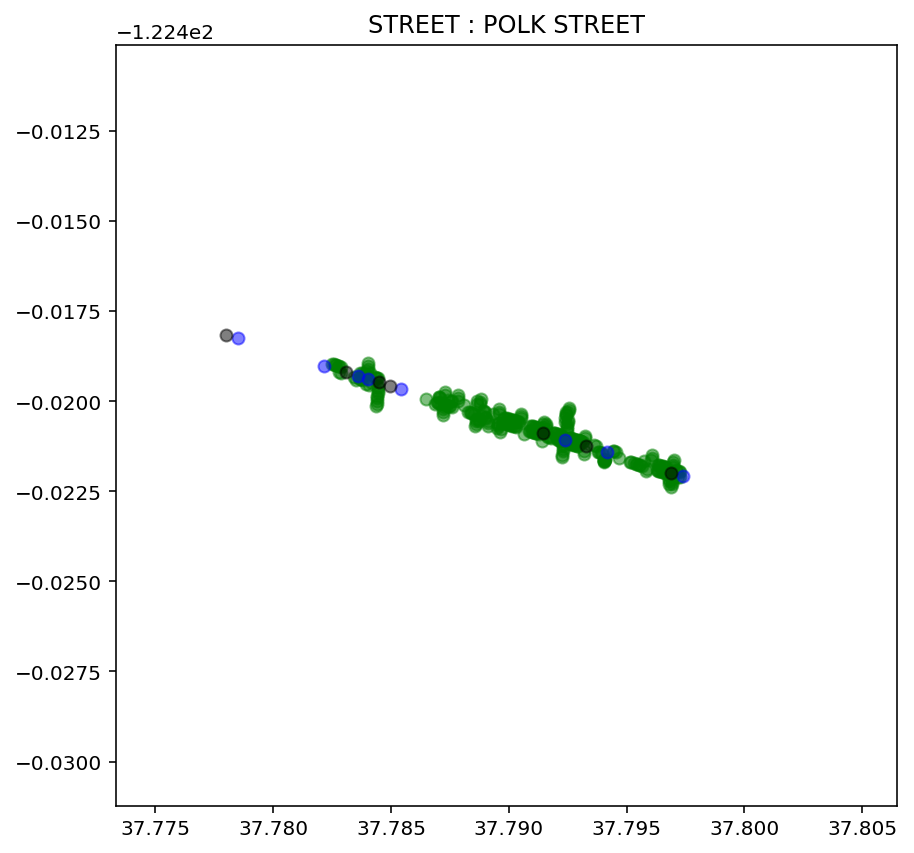

In [34]:
plot_street('POLK STREET', train_df, parking_df)

#### Get Unique Streets

In [35]:
train_streets = list(train_df['Street'].unique())
train_streets = [s.upper() for s in train_streets]

parking_street = list(parking_df['road'].unique())
parking_street = [s.upper() for s in parking_street if s is not None]



In [36]:
train_streets

['MISSION STREET',
 'POLK STREET',
 'VAN NESS AVENUE',
 'LARKIN STREET',
 'PINE STREET',
 '23RD STREET',
 'BRYANT STREET',
 'JESSIE STREET',
 'KEARNY STREET',
 'POST STREET',
 'WASHINGTON STREET',
 'JACKSON STREET',
 'BUSH STREET',
 'LEAVENWORTH STREET',
 'JONES STREET',
 'GEARY STREET',
 'TAYLOR STREET',
 'GROVE STREET',
 'SUTTER STREET',
 'HYDE STREET',
 'MASON STREET',
 'MONTGOMERY STREET',
 'BATTERY STREET',
 'STOCKTON STREET',
 'COLUMBUS AVENUE',
 'REDWOOD STREET']

### change streets to uppercase

In [37]:
train_df['STREET'] = train_df['Street'].map(lambda x : x.upper())
parking_df['STREET'] = parking_df['road'].map(lambda x : x.upper() if x is not None else x)

In [38]:
parking_sm_df = parking_df[parking_df['STREET'].isin(train_streets)]
parking_sm_df.shape

(124185, 15)

### Get unique coordinates

In [39]:
def plot_unique_coords(df, lat_field, lon_field):
    unique = df.groupby([lat_field, lon_field]).size().reset_index()
    lat, lon= unique[lat_field].values, unique[lon_field].values
    return lat, lon

In [40]:
lat_tr, lon_tr = train_df['From_lat'].values, train_df['From_long'].values

In [41]:
lat, lon = plot_unique_coords(parking_sm_df, 'lat', 'lon')
latp, lonp = plot_unique_coords(parking_df, 'lat', 'lon')

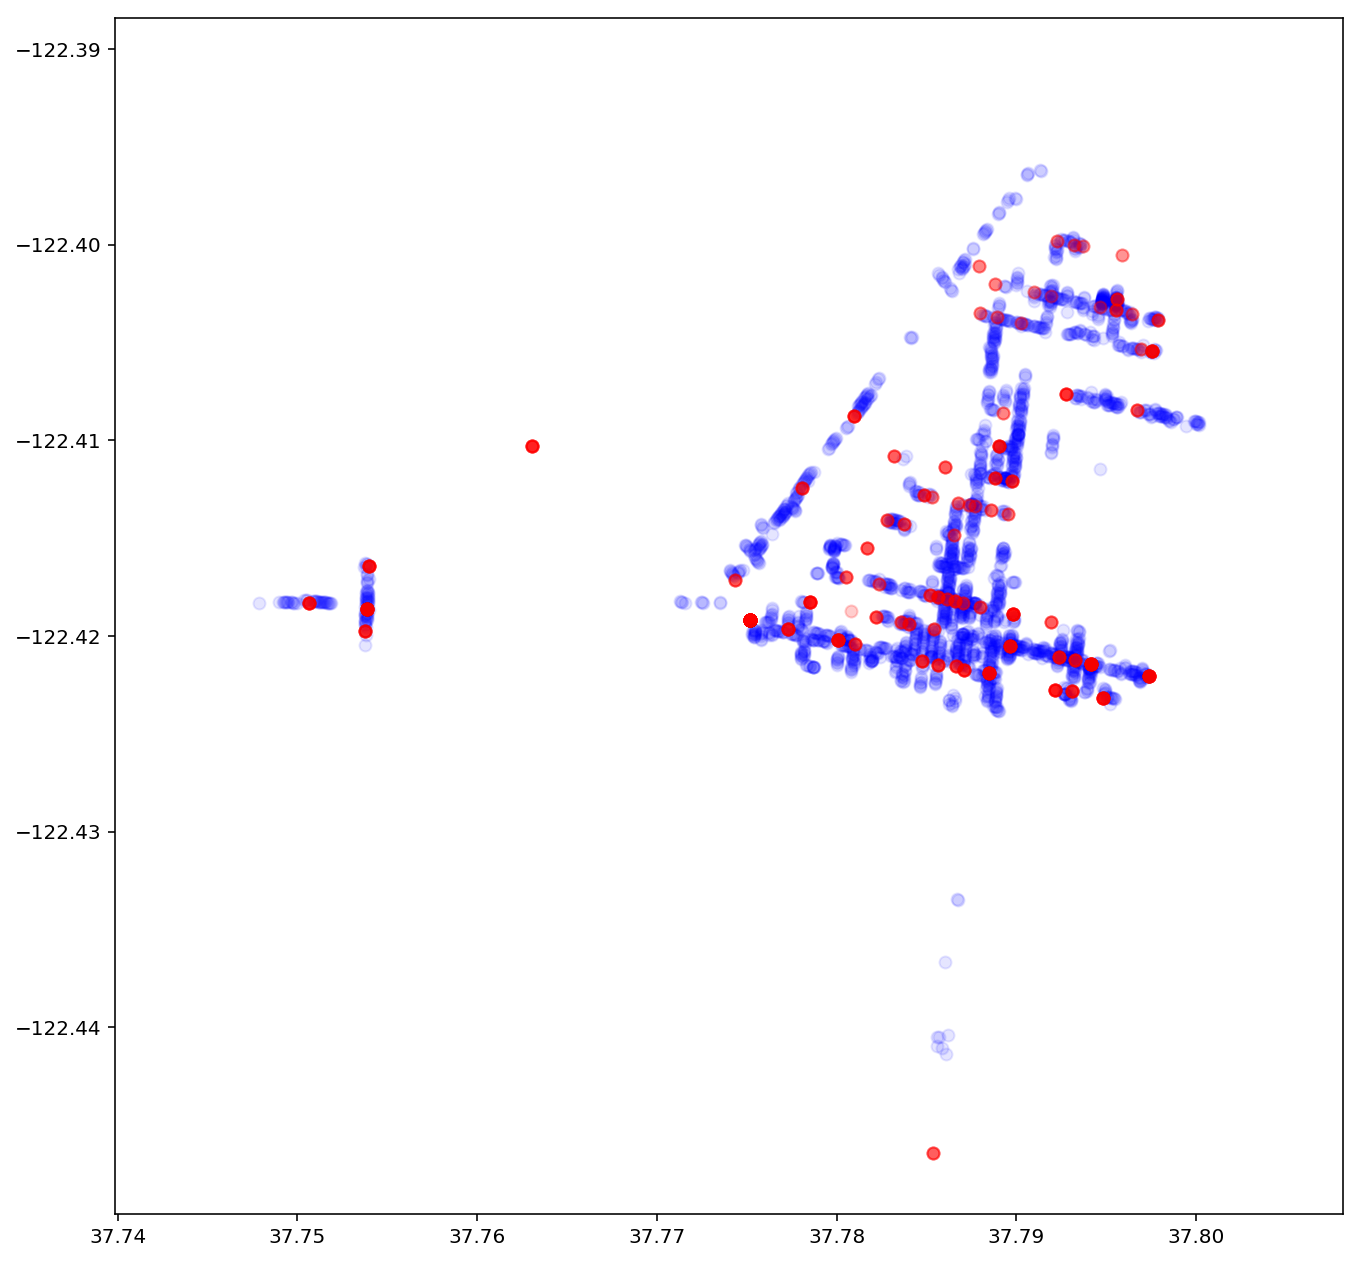

In [42]:

plt.figure(figsize=(11,11))
#plt.scatter(latp, lonp, c='g', alpha = 0.5)
plt.scatter(lat, lon, c='b', alpha=0.1)
plt.scatter(lat_tr, lon_tr, c='r', alpha = 0.1)


### Plotting function for coordinates

In [43]:
def plot_street(STREET):
    train_streets = list(train_df['Street'].unique())
    train_streets = [s.upper() for s in train_streets]
    
    parking_street = list(parking_df['road'].unique())
    parking_street = [s.upper() for s in parking_street if s is not None]

    kearny_t= train_df[train_df['STREET']==STREET]
    kearny_p = parking_sm_df[parking_sm_df['STREET']==STREET]
    
    latF, lonF = plot_unique_coords(kearny_t, 'From_lat', 'From_long')
    latT, lonT = plot_unique_coords(kearny_t, 'To_lat', 'To_long')
    latp, lonp = plot_unique_coords(kearny_p, 'lat', 'lon')
    
    
    plt.figure(figsize=(7,7))
    plt.title('STREET : %s' % STREET)
    plt.scatter(latp, lonp, c='g', alpha = 0.5)
    plt.scatter(latF, lonF, c='b', alpha=0.5)
    plt.scatter(latT, lonT, c='black', alpha = 0.5)

/Users/timlee/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


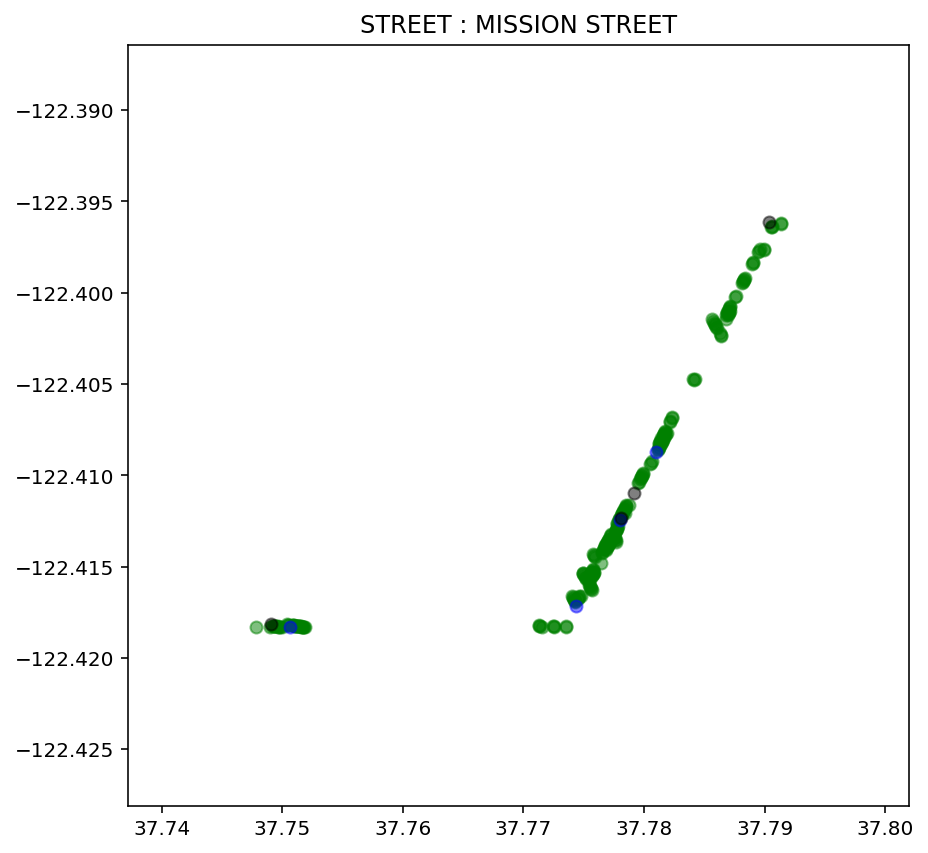

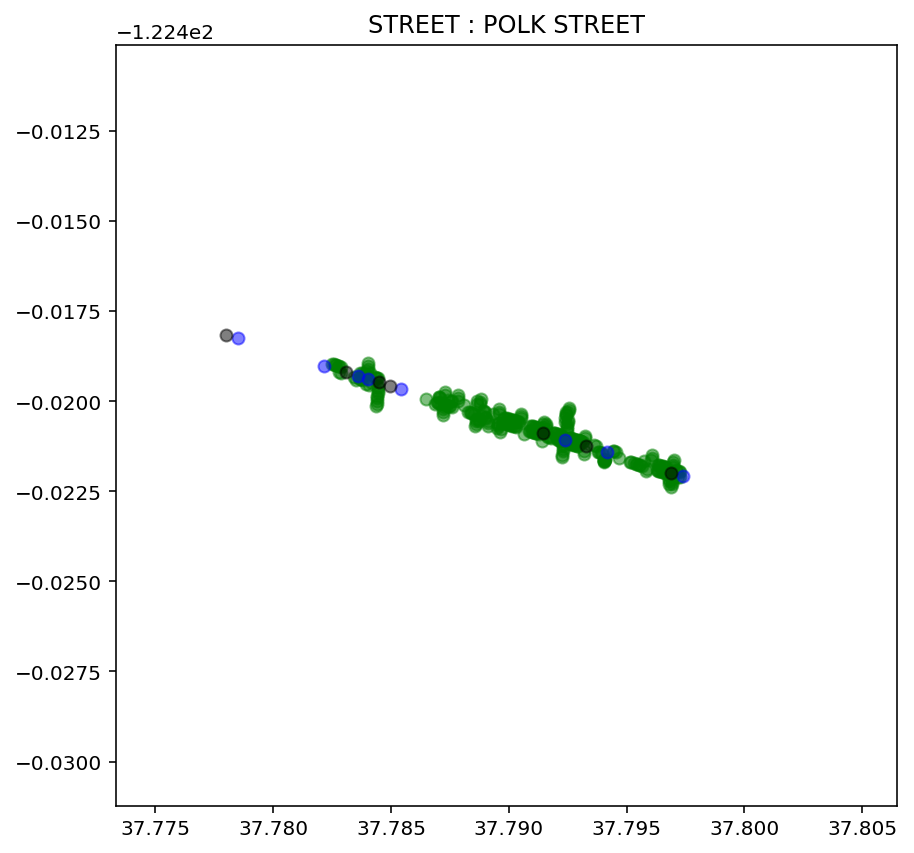

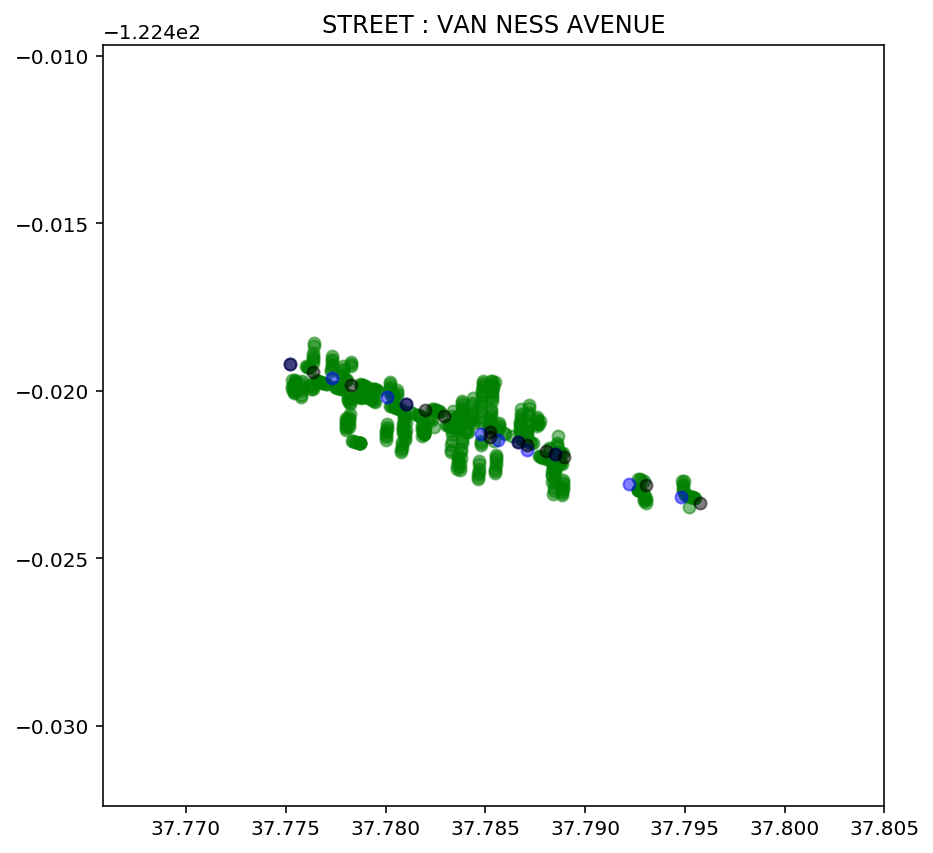

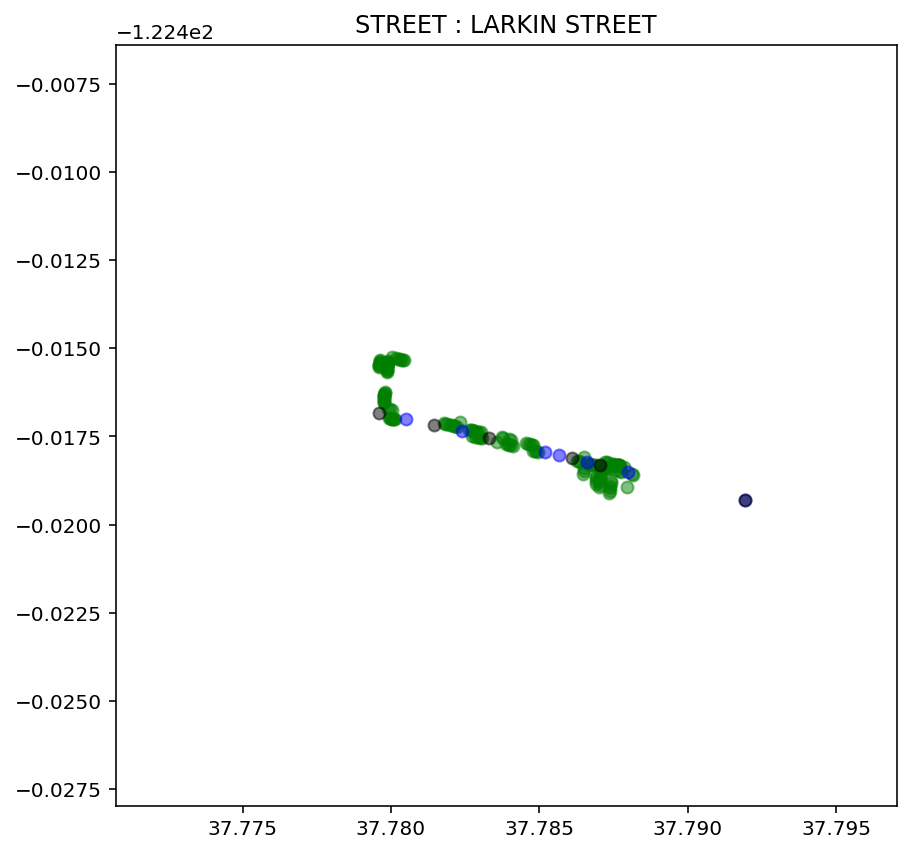

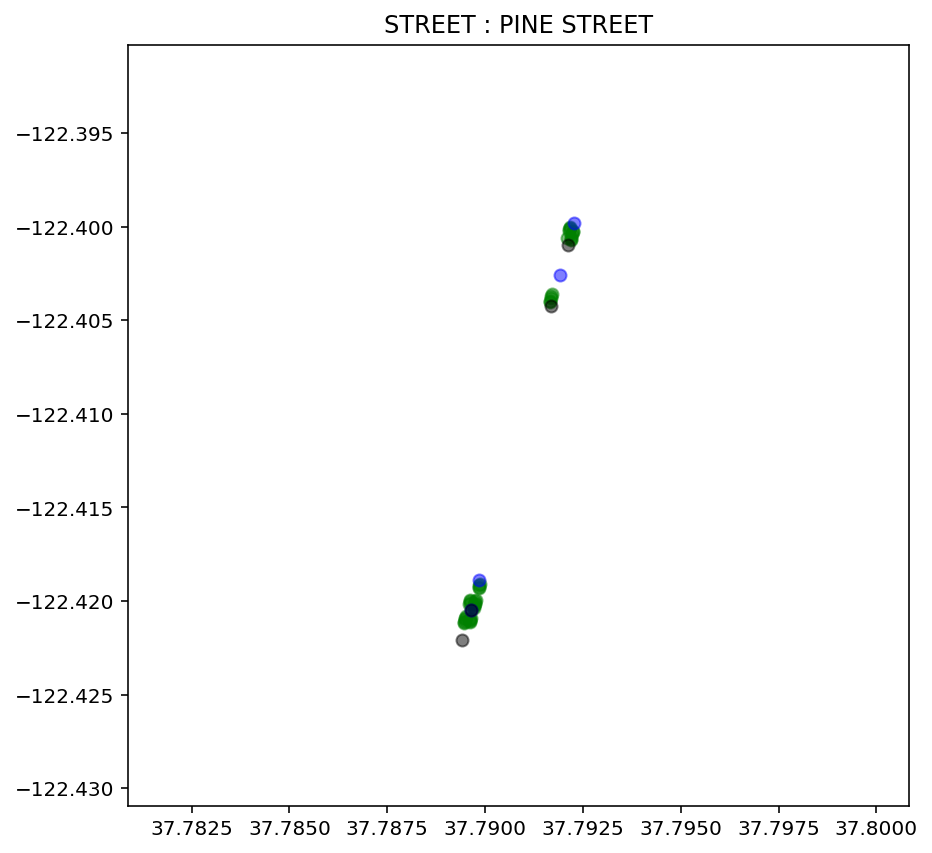

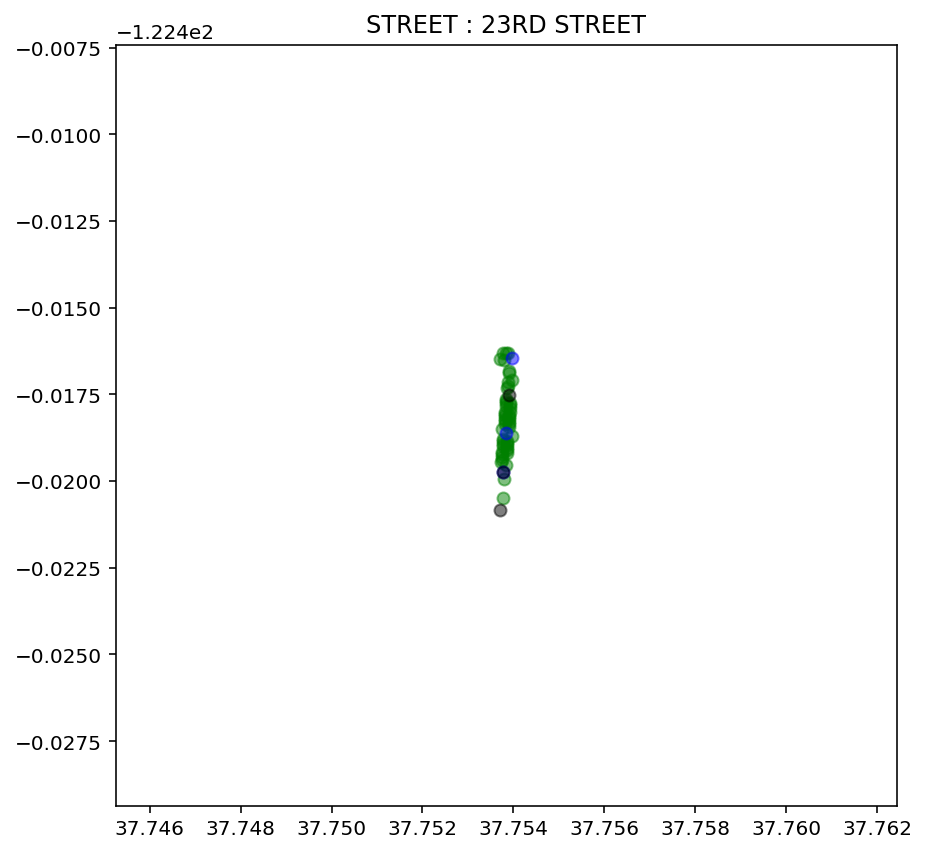

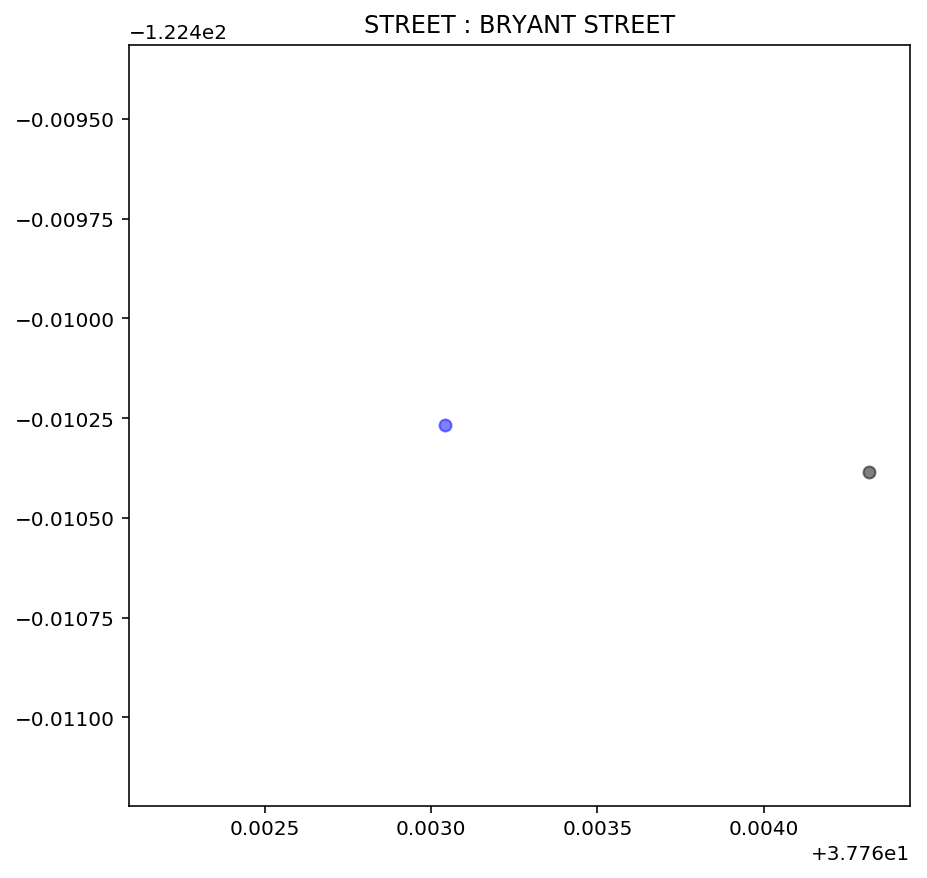

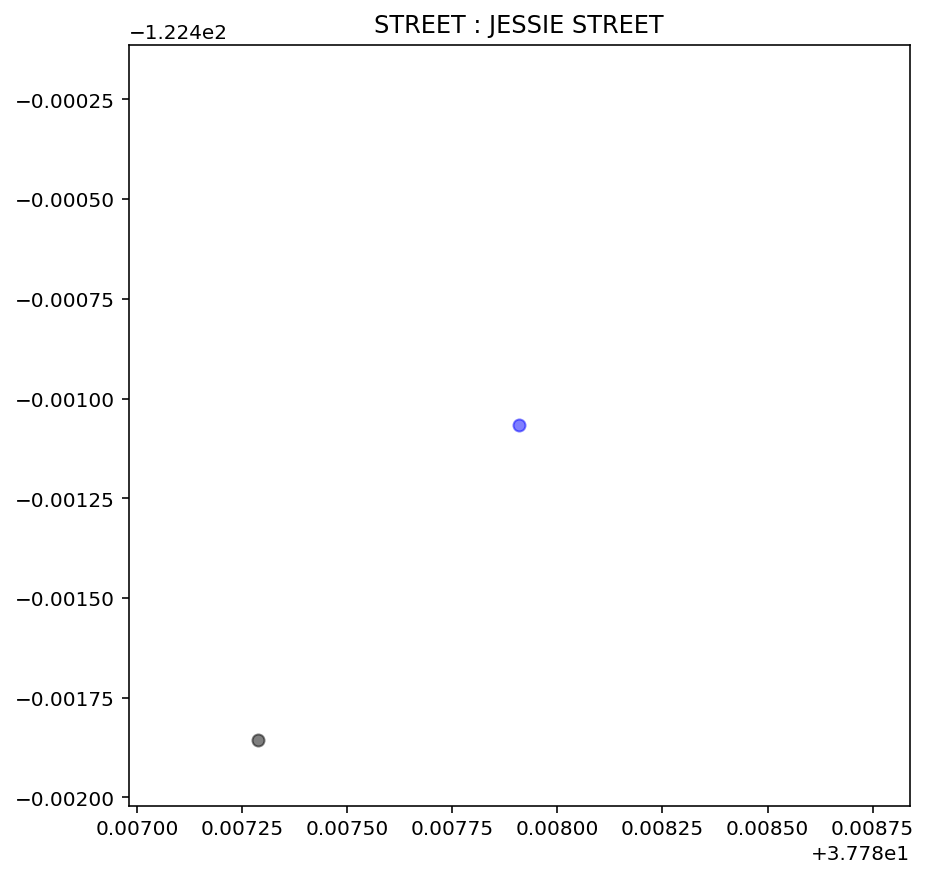

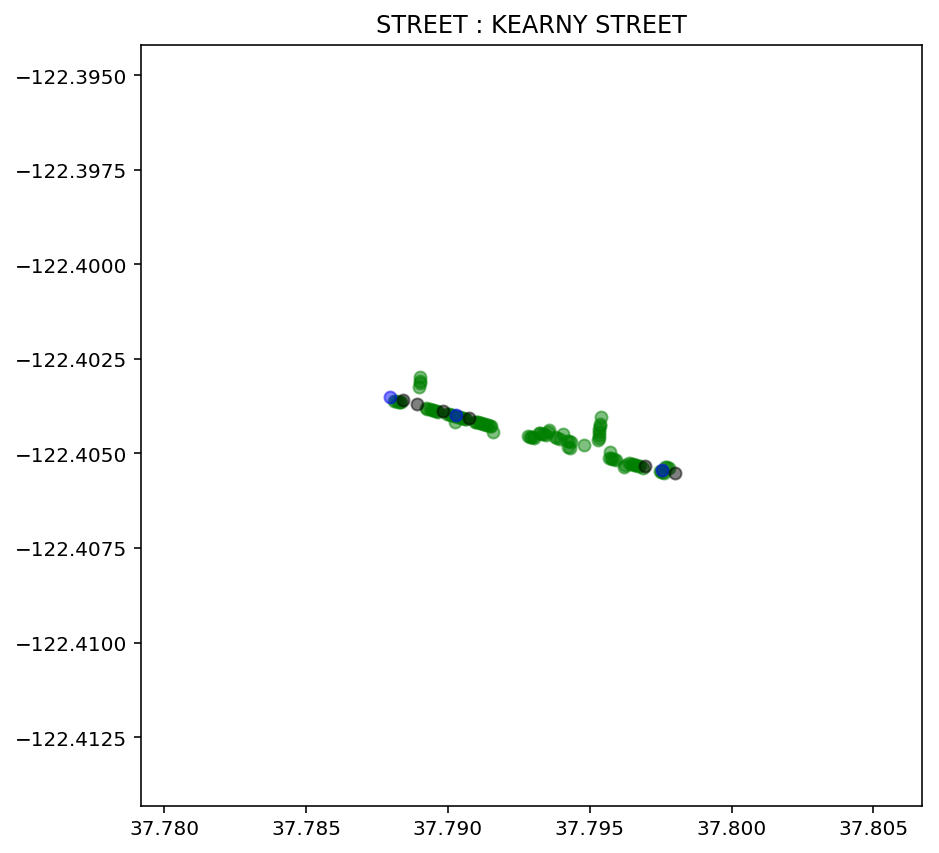

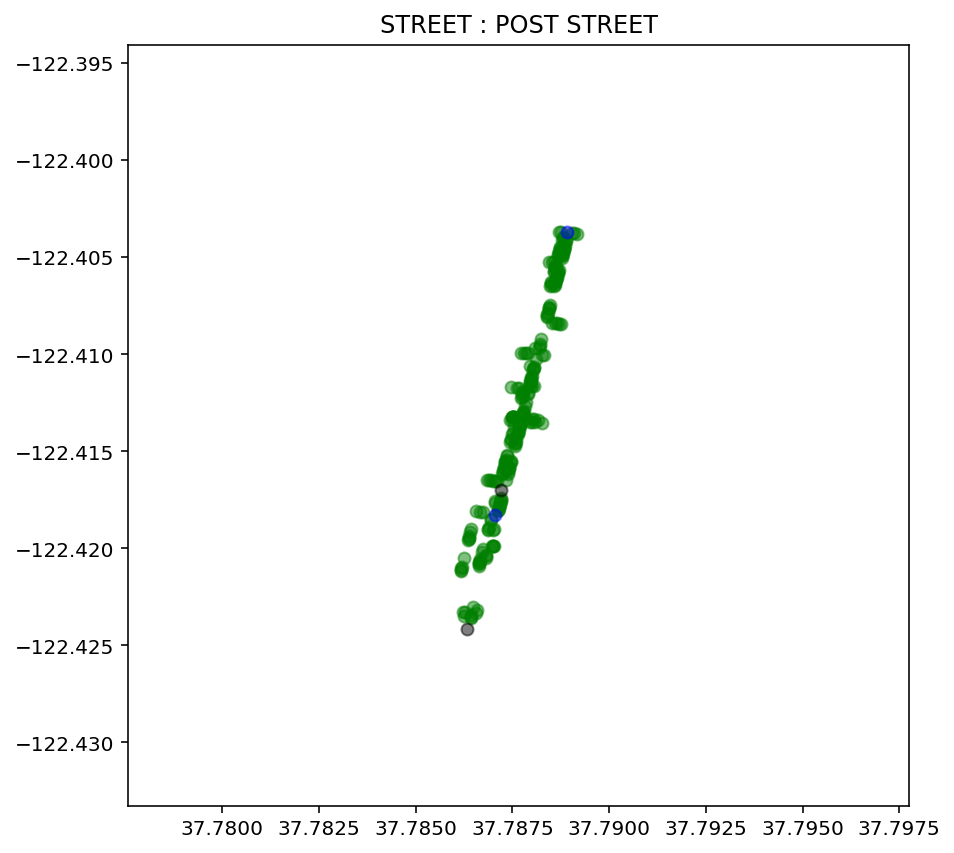

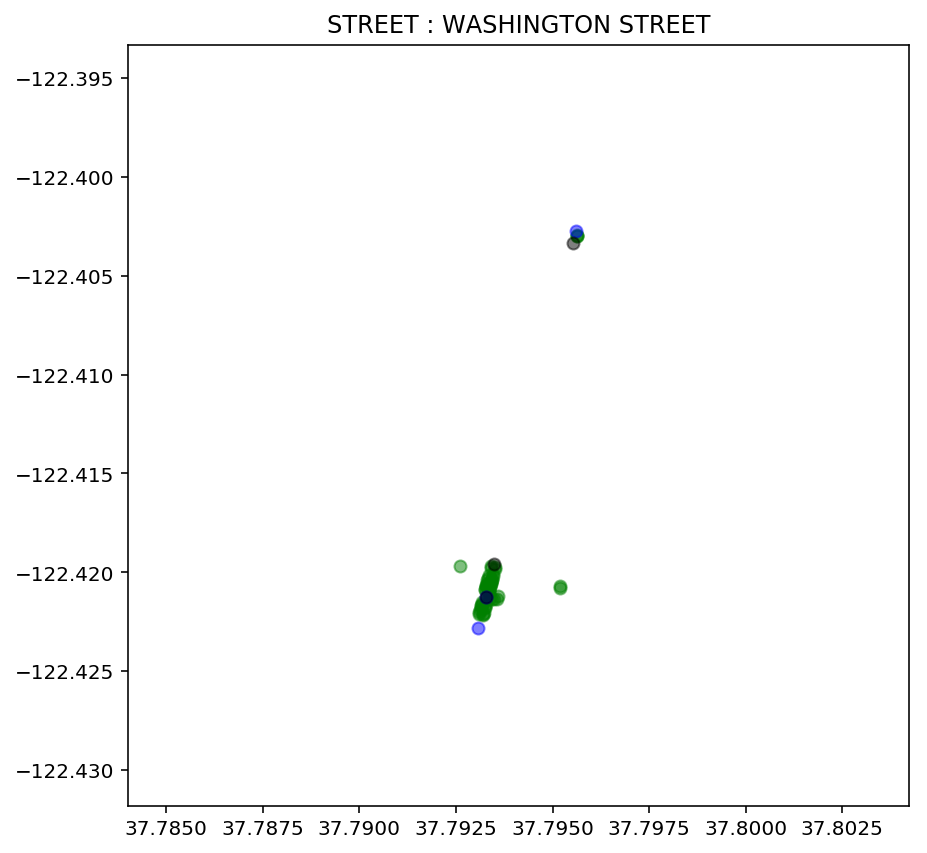

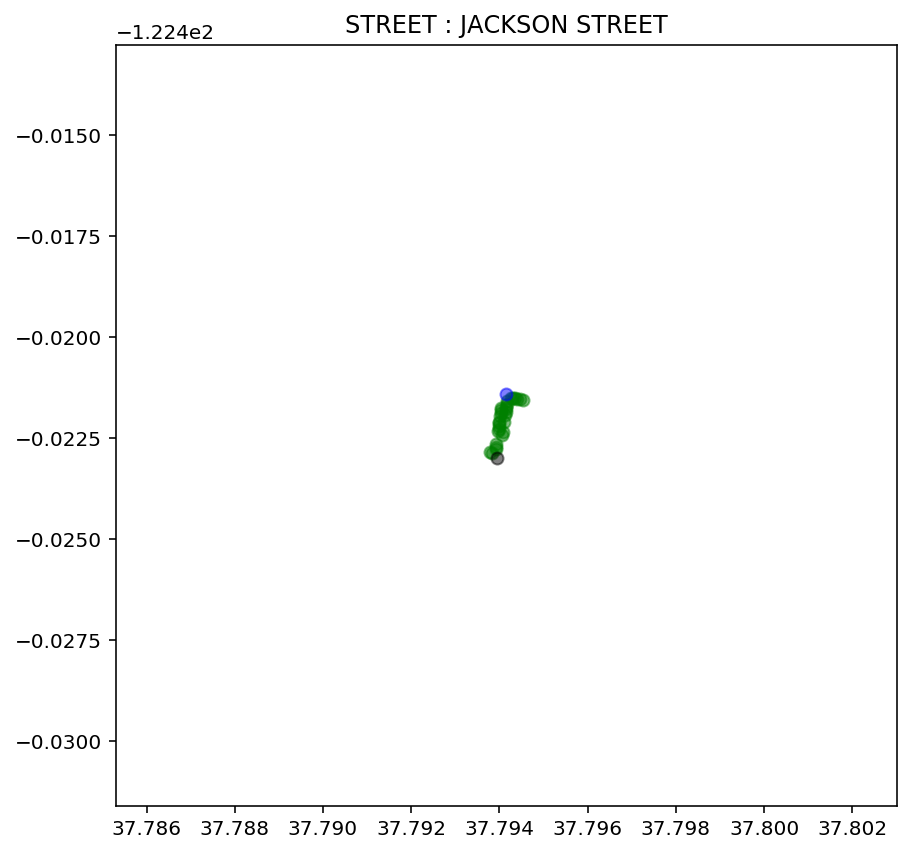

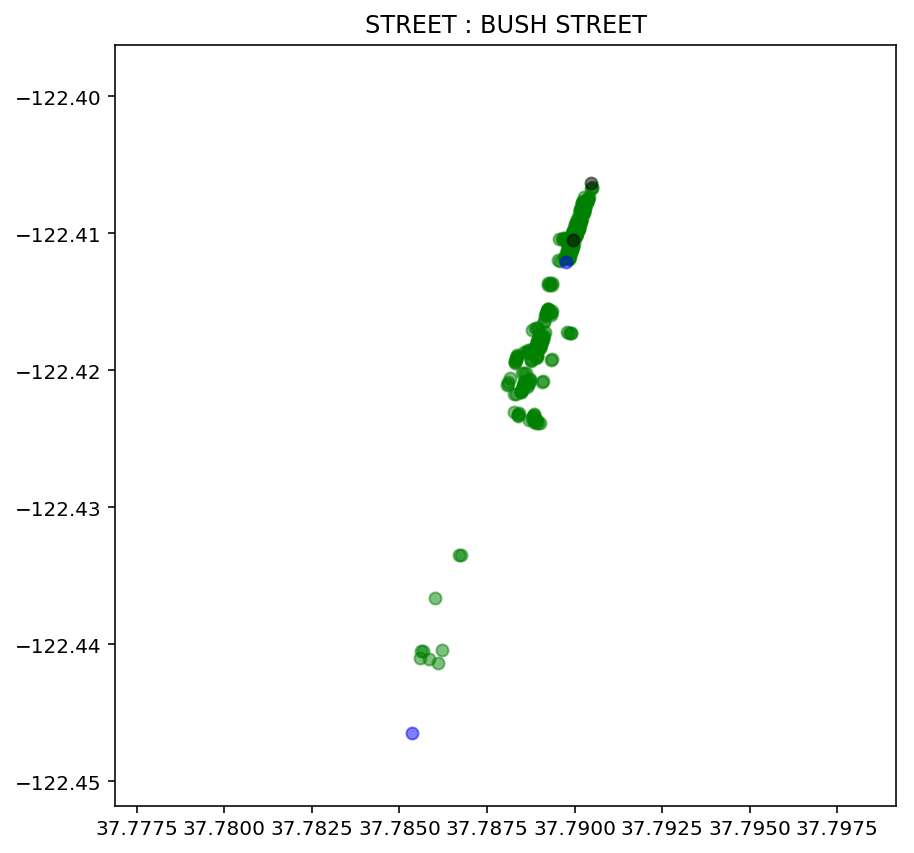

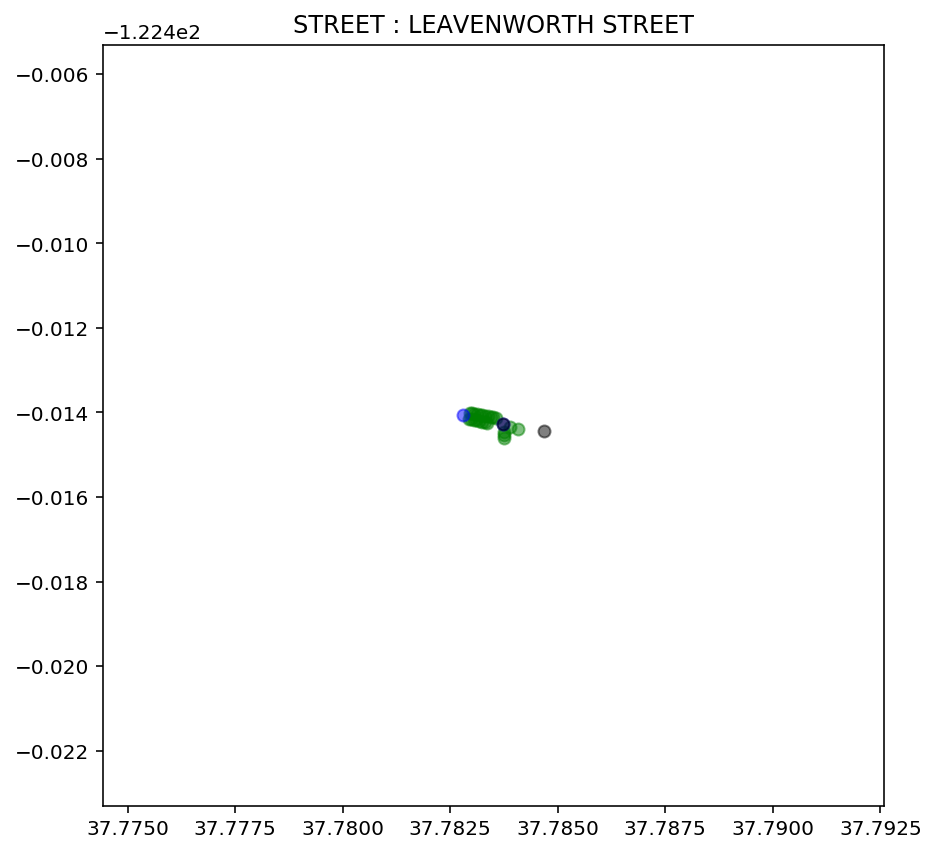

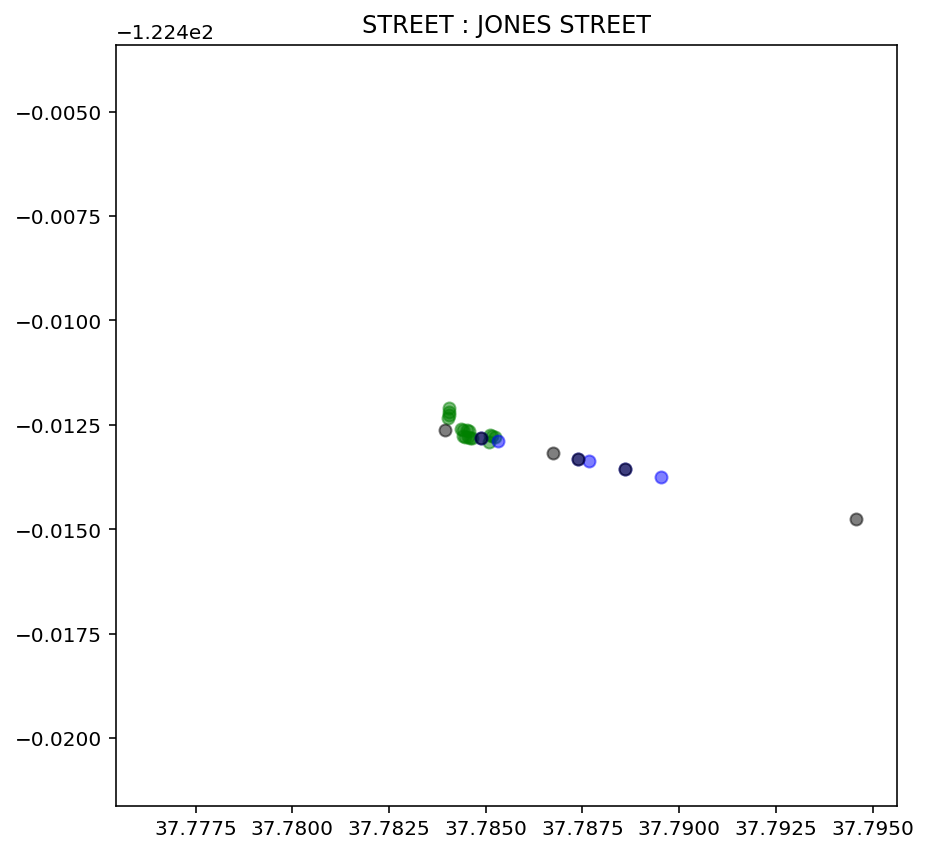

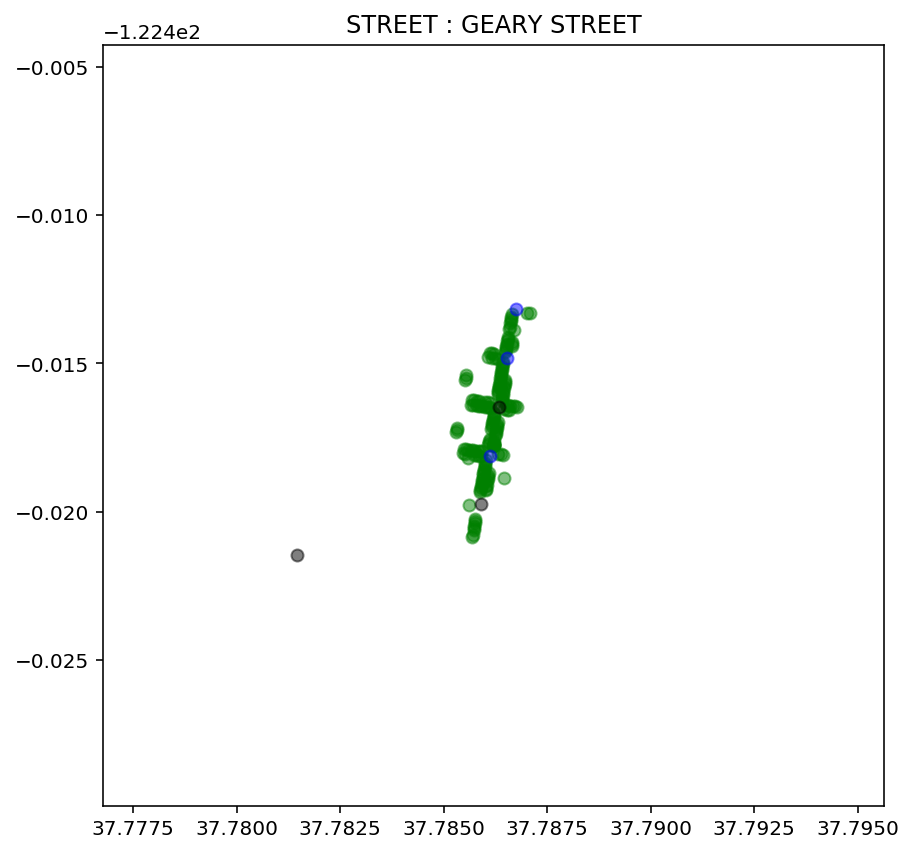

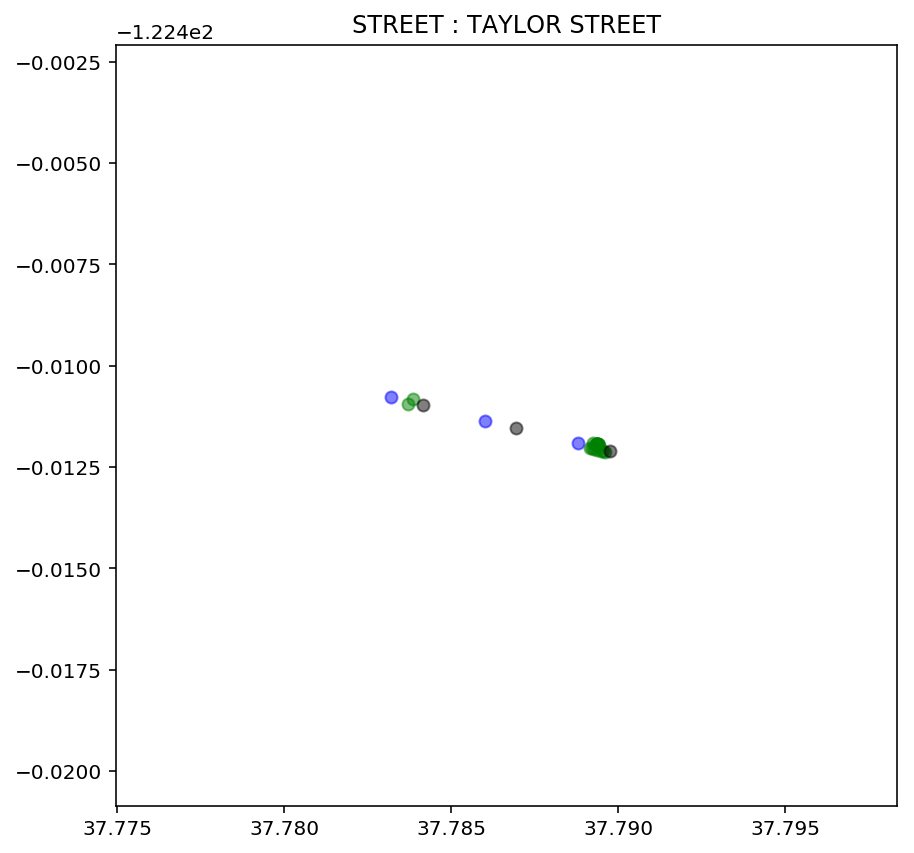

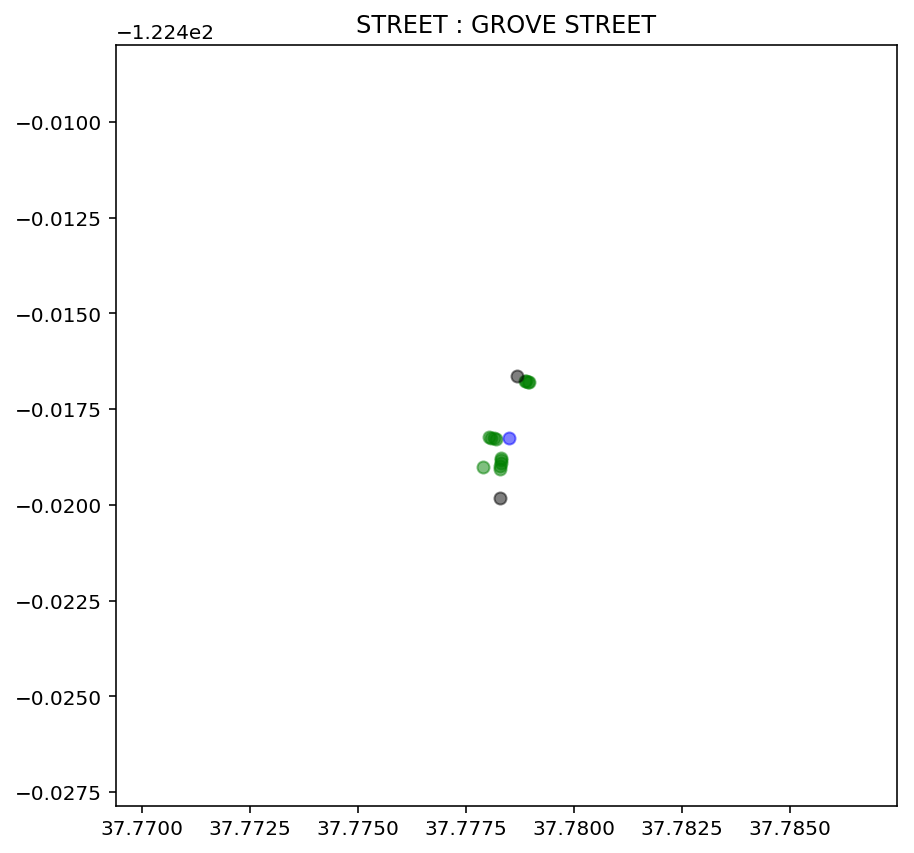

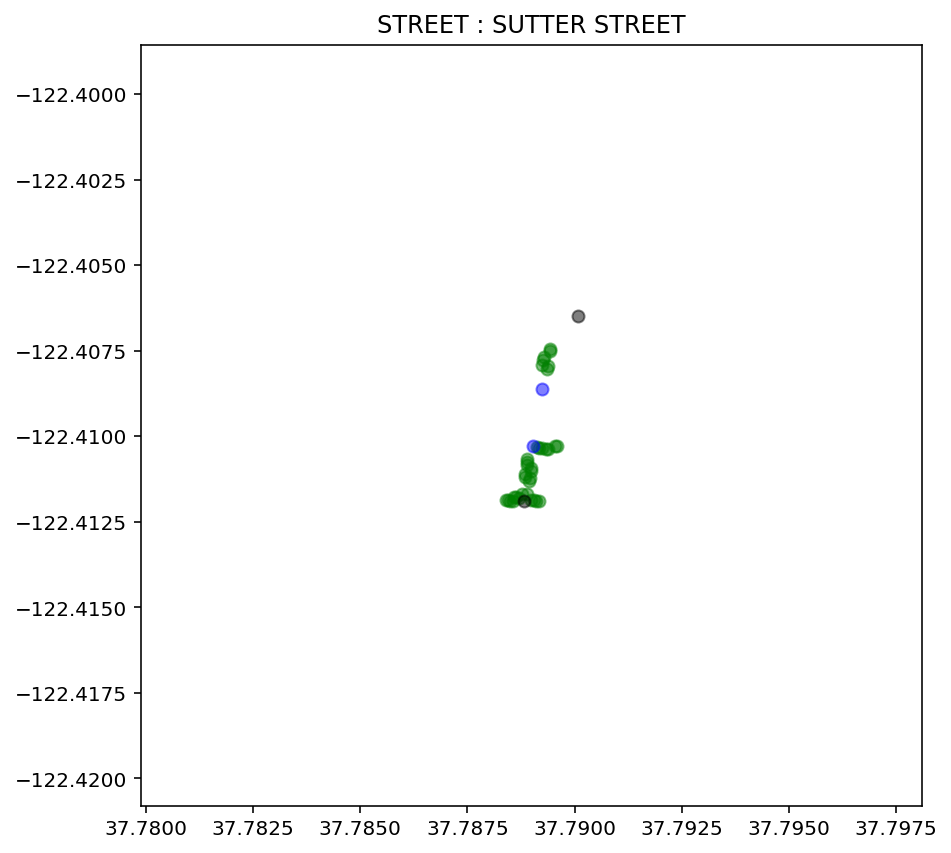

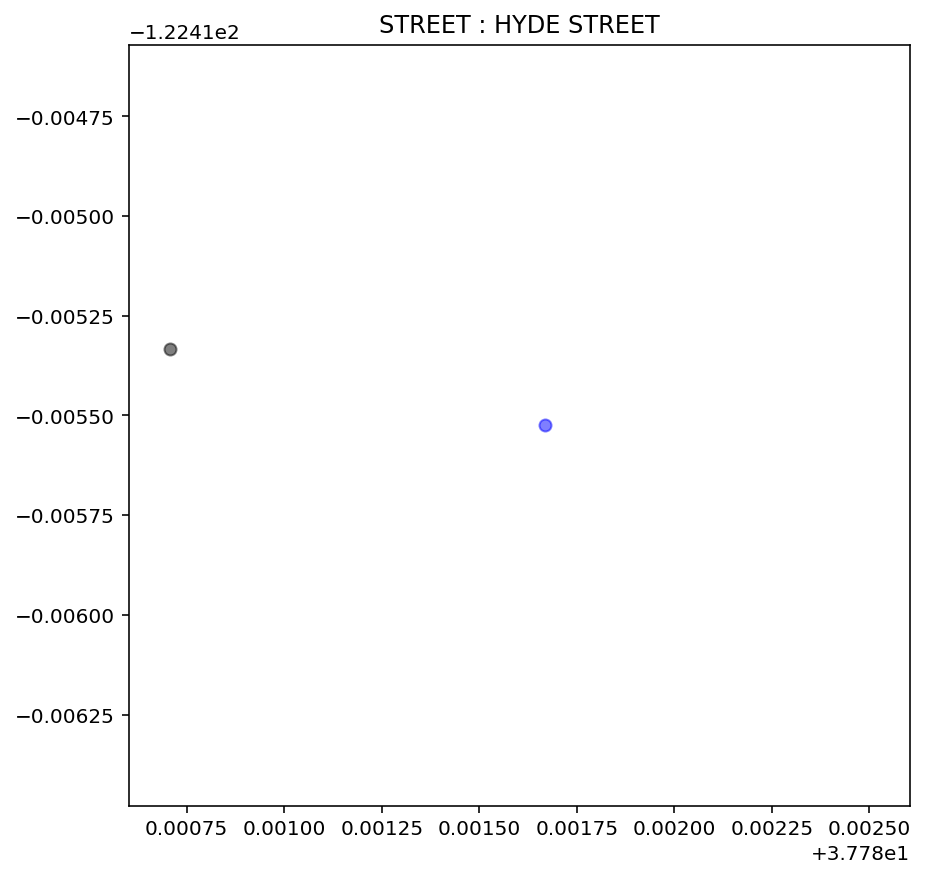

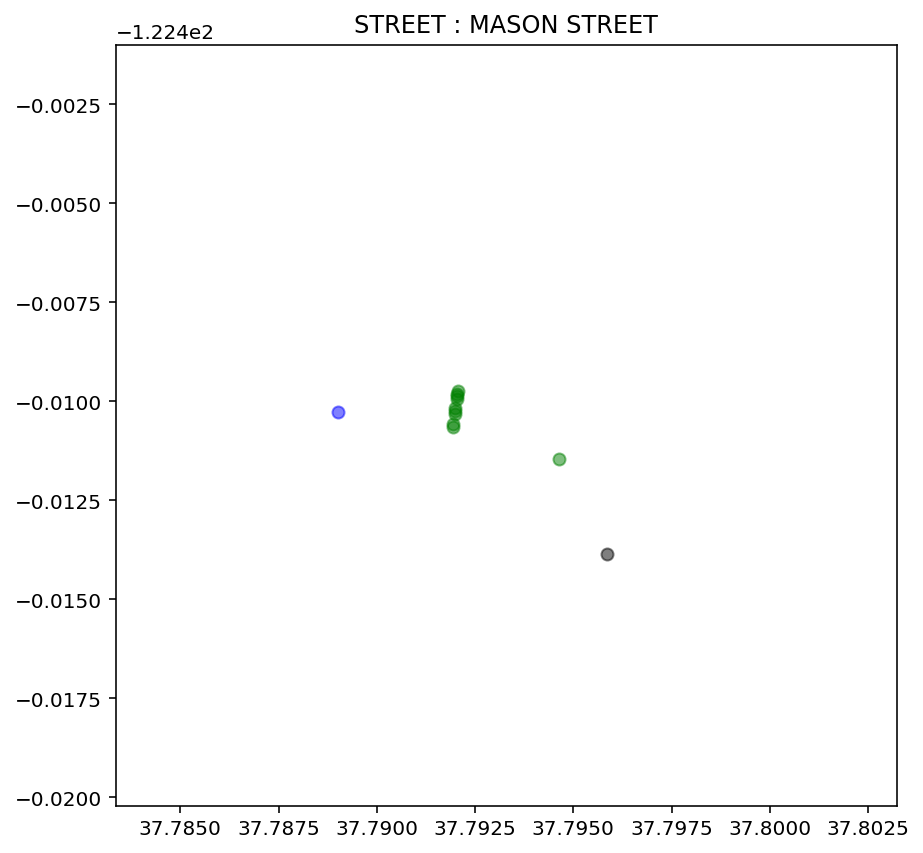

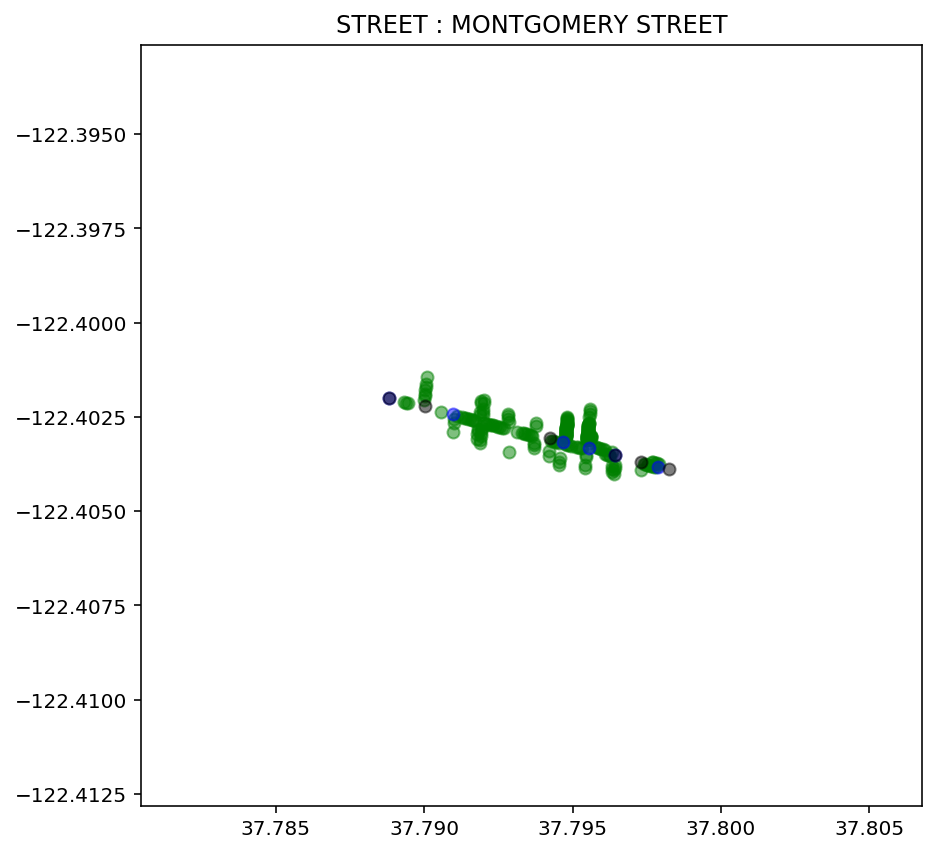

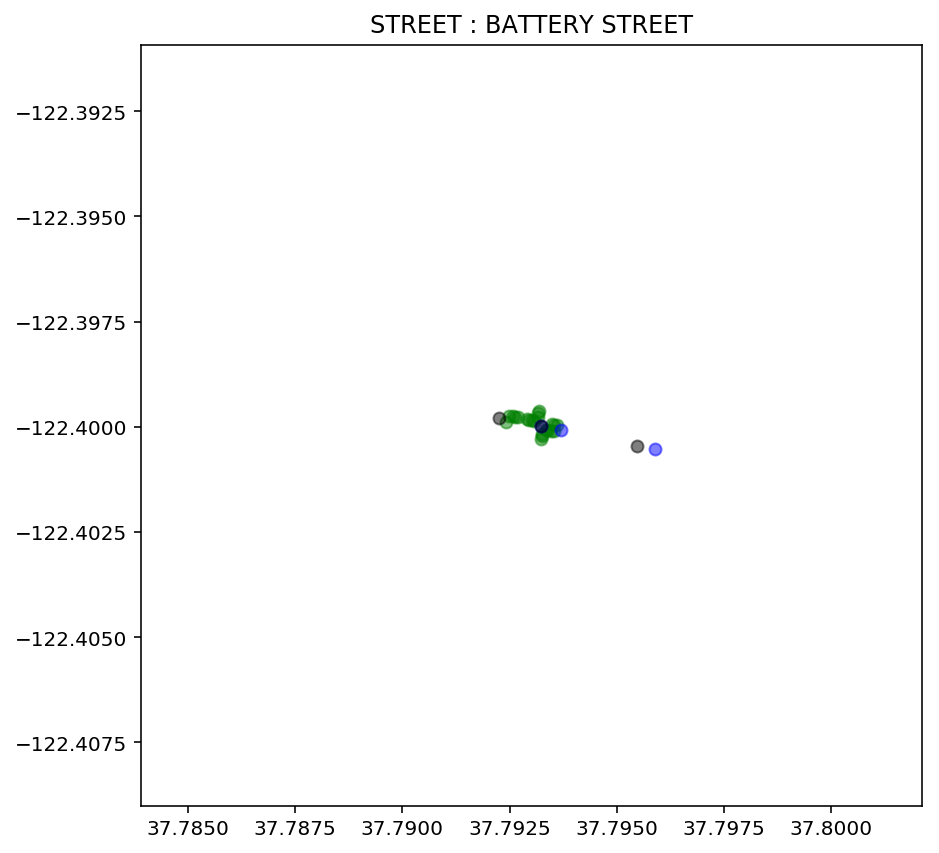

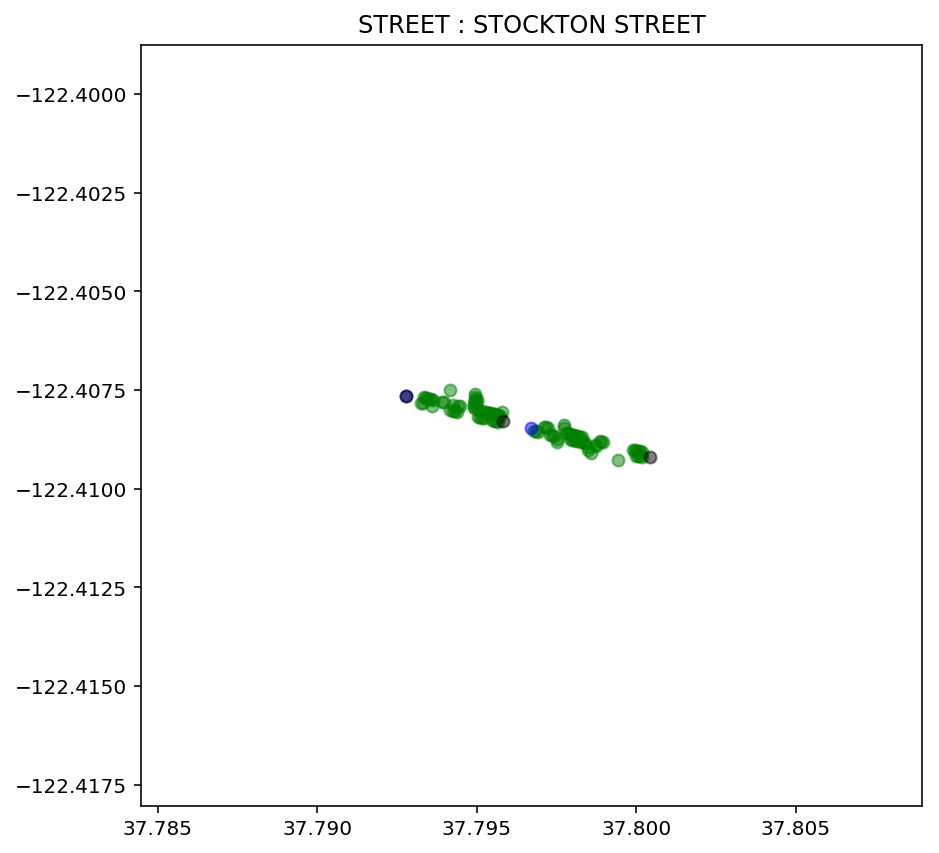

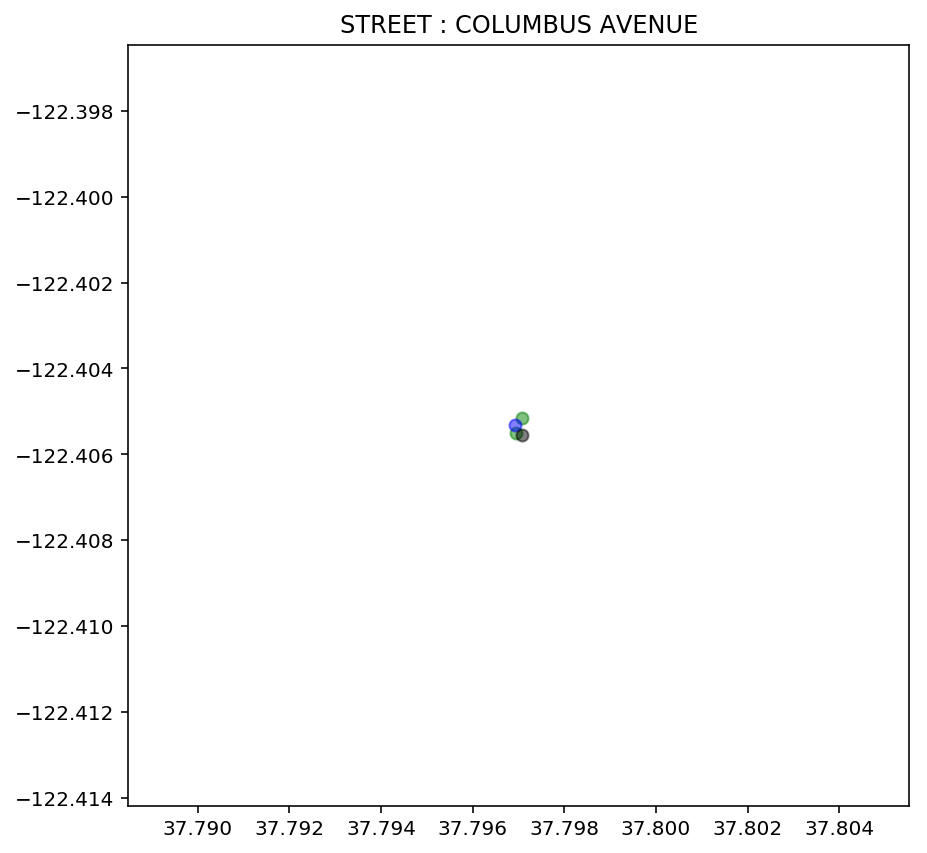

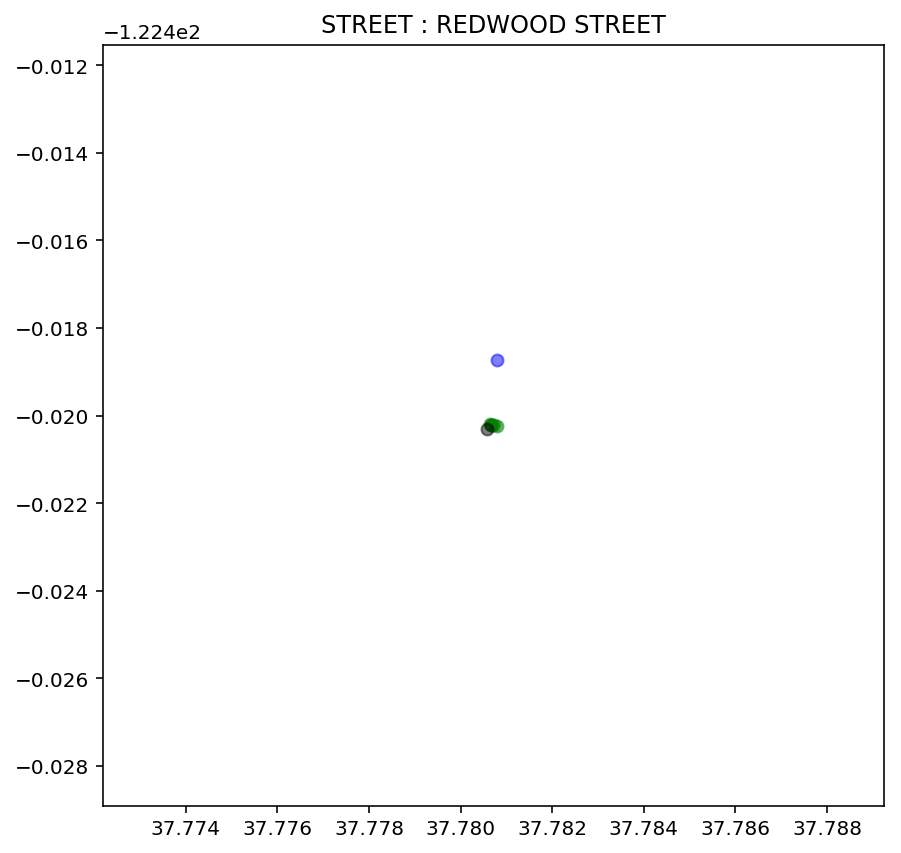

In [44]:
for street in train_streets:
    plot_street(street)

### Sample Overlay of Street 

In [18]:
STREET = 'LARKIN STREET'

In [19]:
kearny_t= train_df[train_df['STREET']==STREET]

In [20]:
kearny_p = parking_sm_df[parking_sm_df['STREET']==STREET]

In [21]:
latF, lonF = plot_unique_coords(kearny_t, 'From_lat', 'From_long')
latT, lonT = plot_unique_coords(kearny_t, 'To_lat', 'To_long')
latp, lonp = plot_unique_coords(kearny_p, 'lat', 'lon')

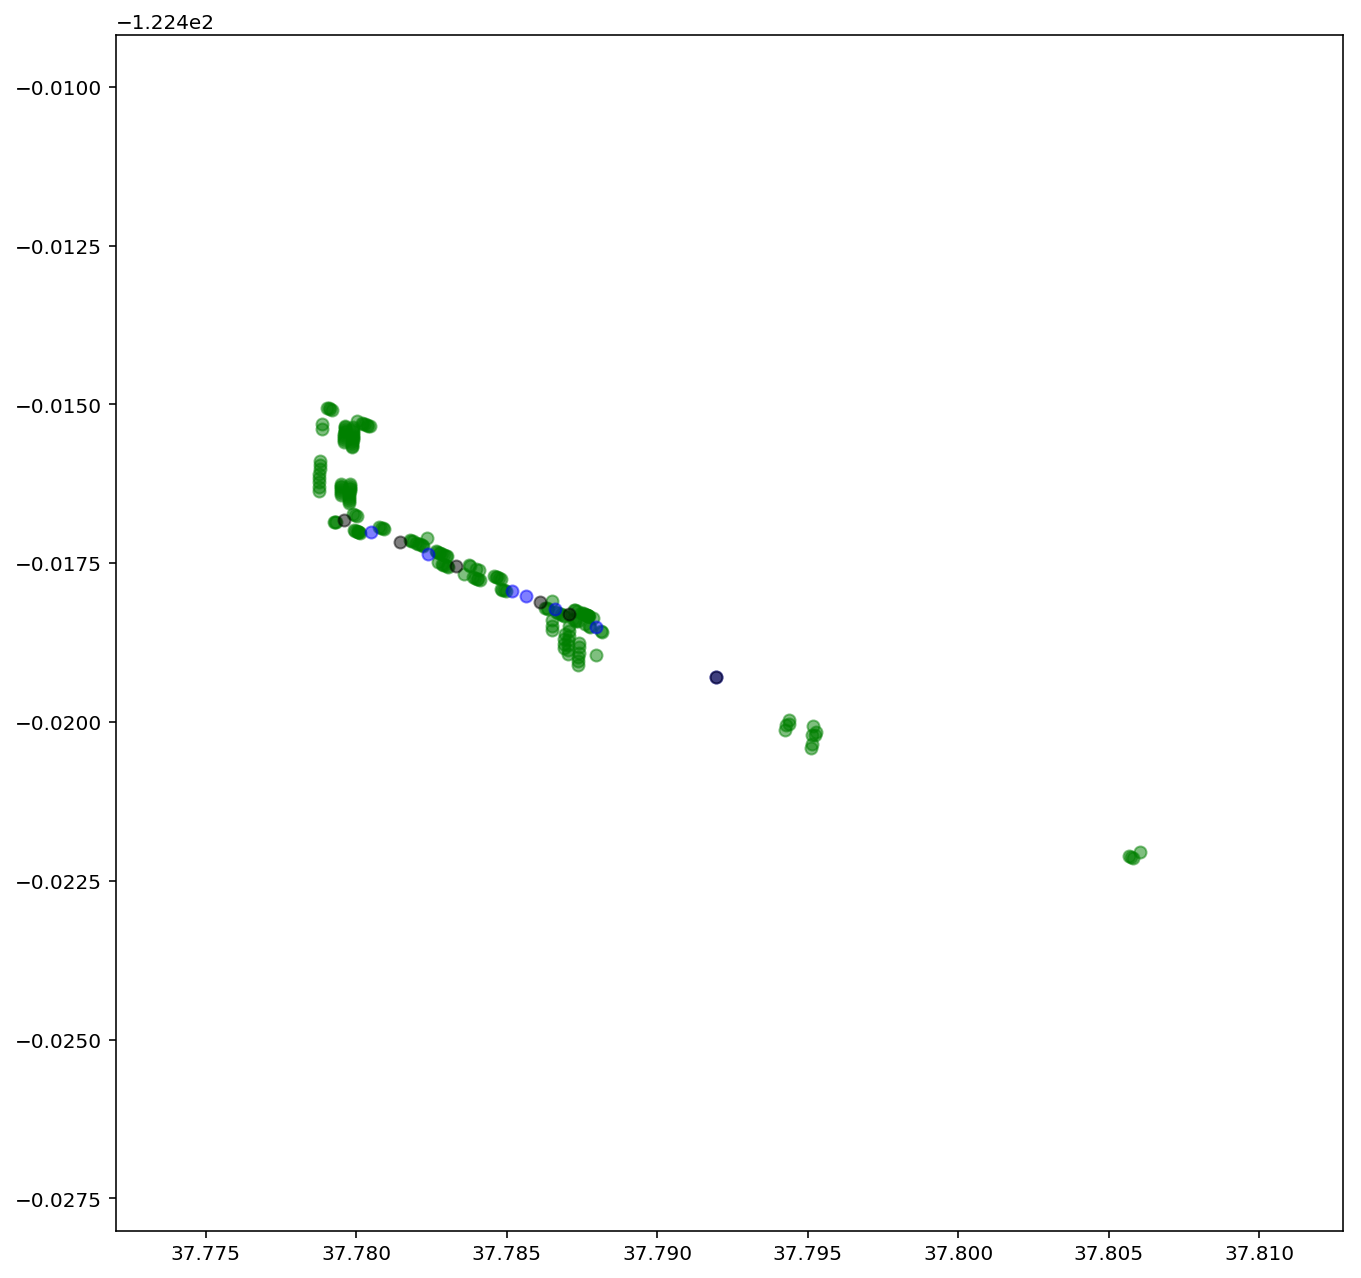

In [22]:

plt.figure(figsize=(11,11))
plt.scatter(latp, lonp, c='g', alpha = 0.5)
plt.scatter(latF, lonF, c='b', alpha=0.5)
plt.scatter(latT, lonT, c='black', alpha = 0.5)


### Bounding box routing (how we filter out other points that over shoot the street

In [23]:
VERT_STREET = ['MISSION STREET', 'PINE STREET', '2ND STREET', 'BRYANT STREET', 
               'POST STREET', 'WASHINGTON STREET', 'JACKSON STREET', 'BUSH STREET', 
               'GEARY STREET', 'GROVE STREET', 'SUTTER STREET', 'COLUMBUS AVENUNE']

In [46]:
dist_parking = parking_sm_df.groupby(['lat','lon','STREET']).size().reset_index()
dist_tr = train_df.groupby(['From_lat','From_long','To_lat','To_long','STREET']).size().reset_index()
dist_tr['STR_SEC'] = dist_tr.index

for latf, lonf, latt,lont, street, ct, id_ in dist_tr.values:
    min_lat = min(latf, latt)
    max_lat = max(latf, latt)
    min_lon = min(lonf, lont)
    max_lon = max(lonf, lont)
    
    if street in VERT_STREET:
        dist_parking.loc[(dist_parking['STREET'] == street) & (dist_parking['lon'] < max_lon) & (dist_parking['lon'] > min_lon),"STR_SEC" ] = id_ 
    else:
        dist_parking.loc[(dist_parking['STREET'] == street) & (dist_parking['lat'] < max_lat) & (dist_parking['lat'] > min_lat) ,"STR_SEC" ] = id_ 
        
    

### Once all the points have tagged, we only filter for parking between street segments

In [47]:
rejoined_parking = parking_sm_df.merge(dist_parking[['lat','lon','STR_SEC']], how ='left', on=['lat','lon'])
rejoined_parking = rejoined_parking[rejoined_parking['STR_SEC'].isna()!=True].copy()

KeyError: 'STR_SEC'

In [ ]:
rejoined_parking.shape

### Plot the remaining points

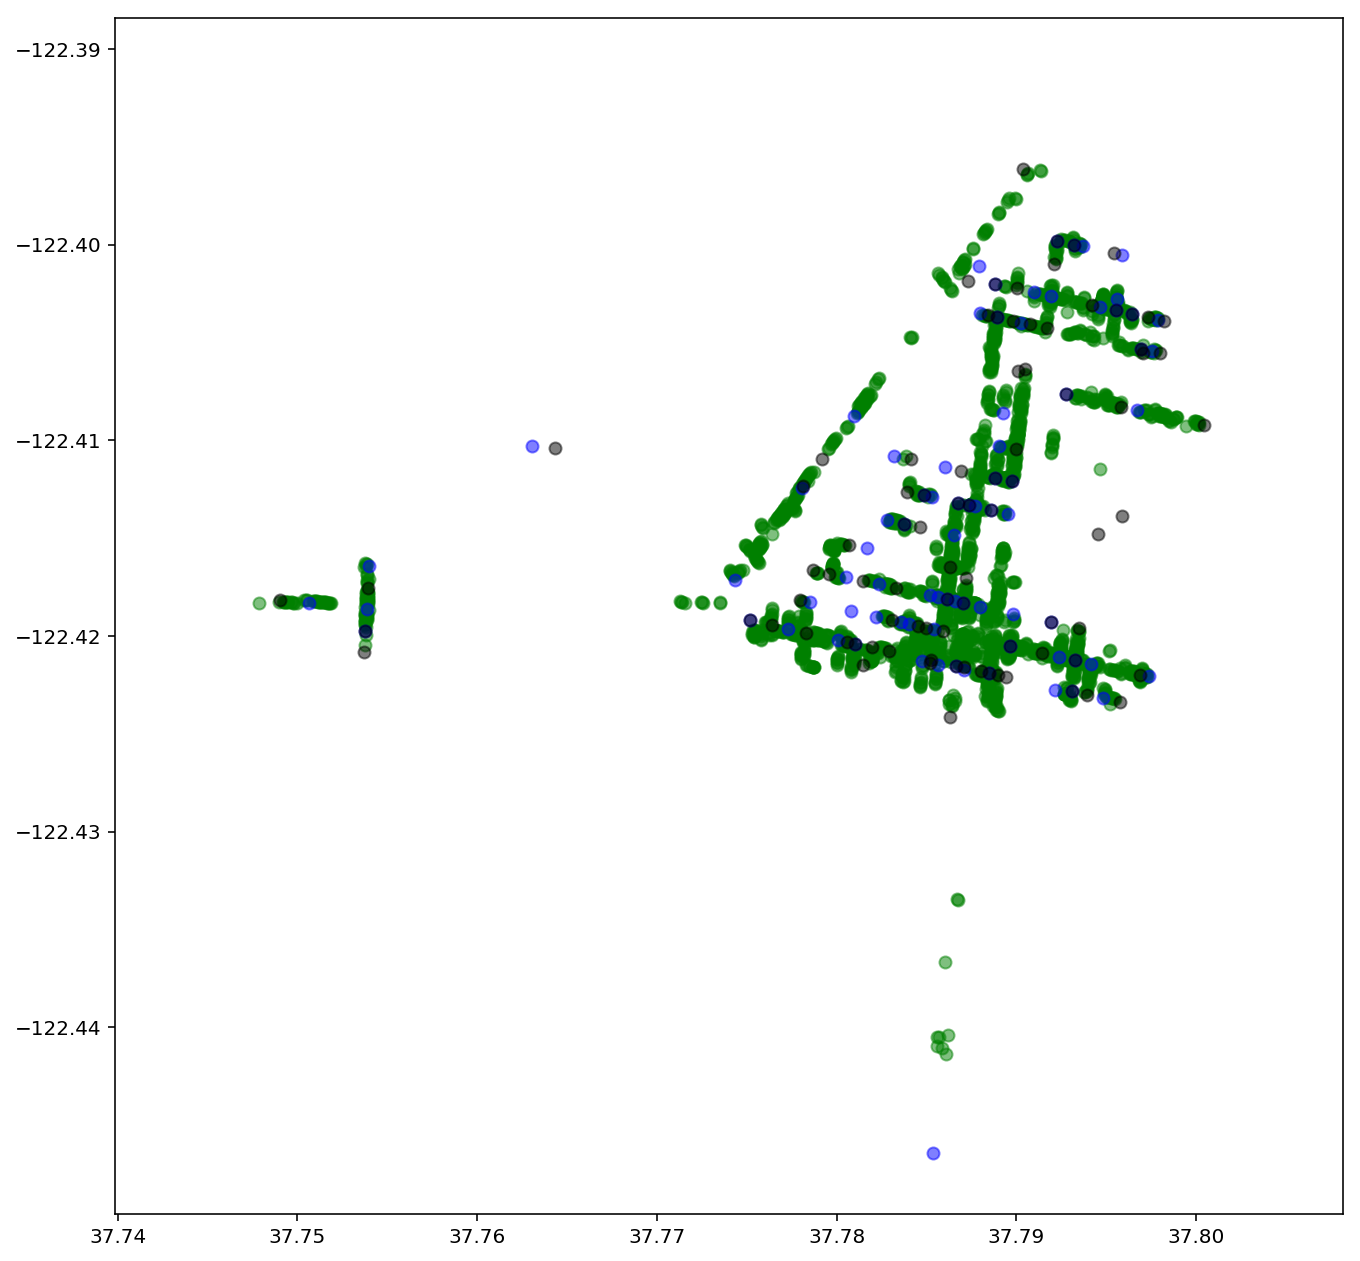

In [48]:
latF, lonF = plot_unique_coords(train_df, 'From_lat', 'From_long')
latT, lonT = plot_unique_coords(train_df, 'To_lat', 'To_long')
latp, lonp = plot_unique_coords(rejoined_parking, 'lat', 'lon')

plt.figure(figsize=(11,11))
plt.scatter(latp, lonp, c='g', alpha = 0.5)
plt.scatter(latF, lonF, c='b', alpha=0.5)
plt.scatter(latT, lonT, c='black', alpha = 0.5)

### Add join columns to training data

In [49]:
join_cols = ['From_lat','From_long','To_lat','To_long']
train_df = train_df.merge(dist_tr[join_cols+['STR_SEC']], how ='left', on =join_cols)

# Double checking by different streets

In [50]:
parking_df, train_df, test_df = add_street_sections(train_df, test_df)

loading cached copy
Time it took: 2.163419246673584
Identifying key streets...
Filtering down the parking data ...
measuring parking coords within FROM TO bounds ...
Adding street section ids to train and parking ...
Complete


### Check out section 6
### Check out section 26

             Street               From             To
11    Larkin Street  McAllister Street  Fulton Street
267   Larkin Street  McAllister Street  Fulton Street
450   Larkin Street  McAllister Street  Fulton Street
492   Larkin Street  McAllister Street  Fulton Street
696   Larkin Street  McAllister Street  Fulton Street
697   Larkin Street  McAllister Street  Fulton Street
807   Larkin Street  McAllister Street  Fulton Street
889   Larkin Street  McAllister Street  Fulton Street
1028  Larkin Street  McAllister Street  Fulton Street


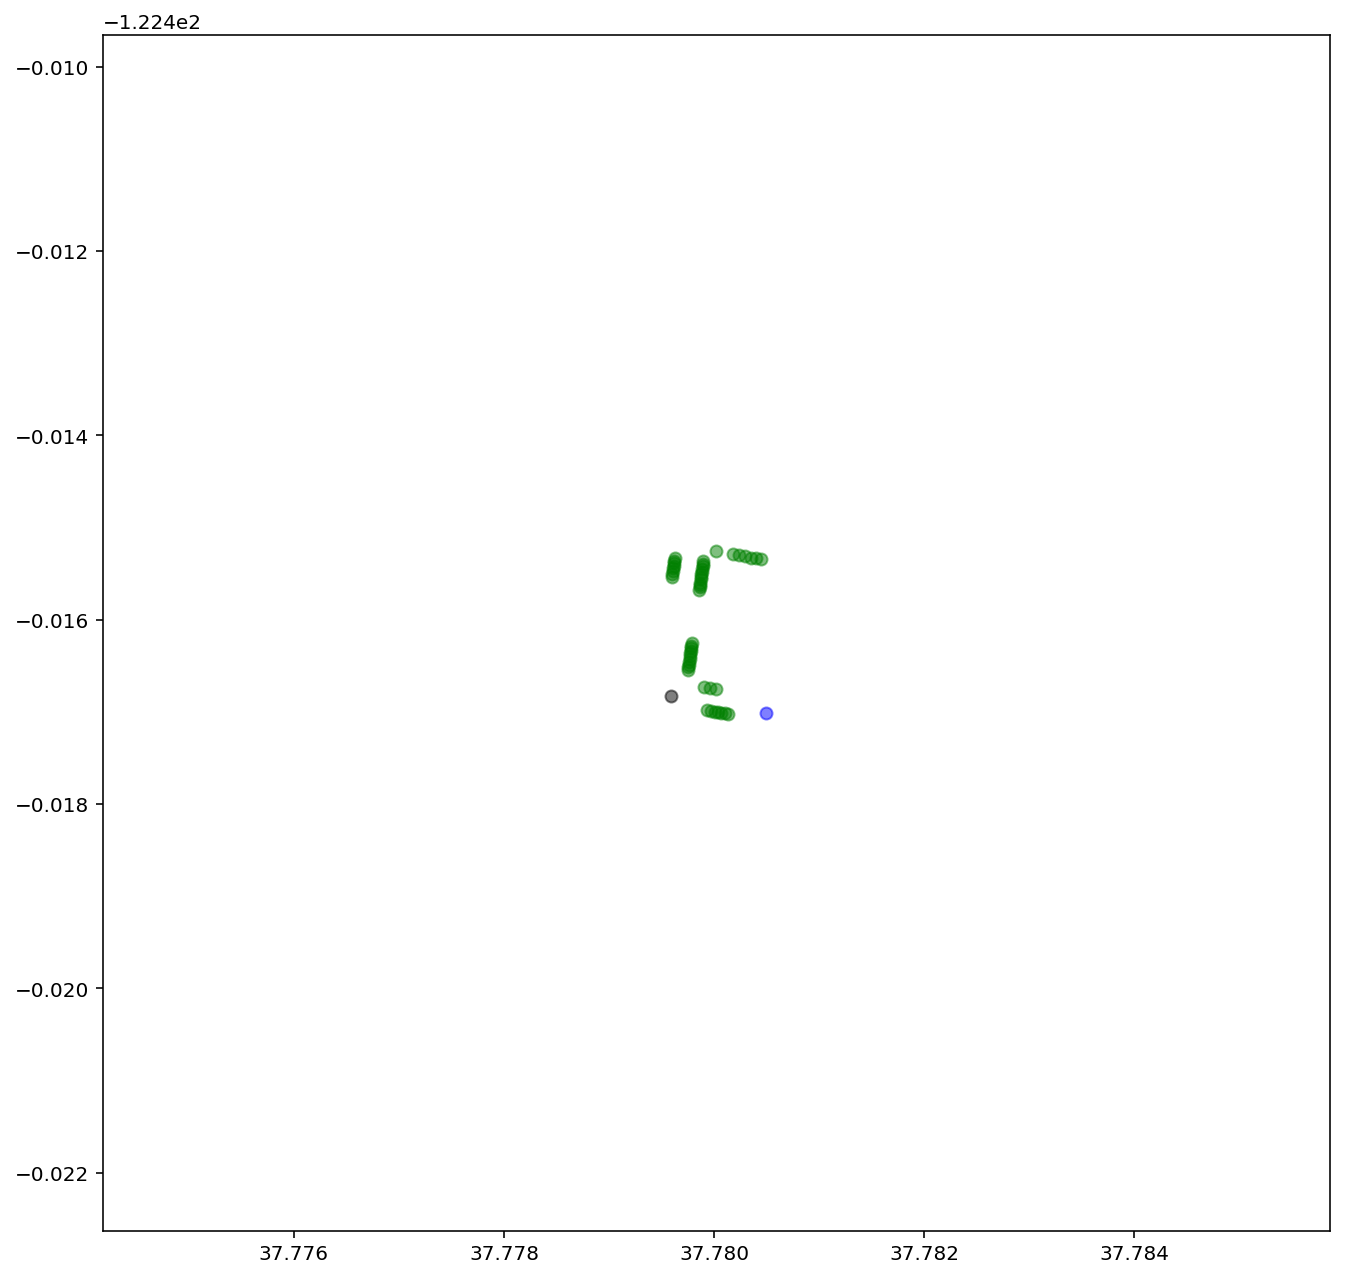

In [66]:
section_number = 19
print(train_df.loc[train_df['STR_SEC']==section_number, ['Street', 'From', 'To']])
latF, lonF = plot_unique_coords(train_df[train_df['STR_SEC']==section_number], 'From_lat', 'From_long')
latT, lonT = plot_unique_coords(train_df[train_df['STR_SEC']==section_number], 'To_lat', 'To_long')
latp, lonp = plot_unique_coords(parking_df[parking_df['STR_SEC']==section_number], 'lat', 'lon')

plt.figure(figsize=(11,11))
plt.scatter(latp, lonp, c='g', alpha = 0.5)
plt.scatter(latF, lonF, c='b', alpha=0.5)
plt.scatter(latT, lonT, c='black', alpha = 0.5)

                  Street         From           To
255   Leavenworth Street  Turk Street  Eddy Street
256   Leavenworth Street  Turk Street  Eddy Street
673   Leavenworth Street  Turk Street  Eddy Street
674   Leavenworth Street  Turk Street  Eddy Street
795   Leavenworth Street  Turk Street  Eddy Street
878   Leavenworth Street  Turk Street  Eddy Street
1006  Leavenworth Street  Turk Street  Eddy Street
1098  Leavenworth Street  Turk Street  Eddy Street
1099  Leavenworth Street  Turk Street  Eddy Street


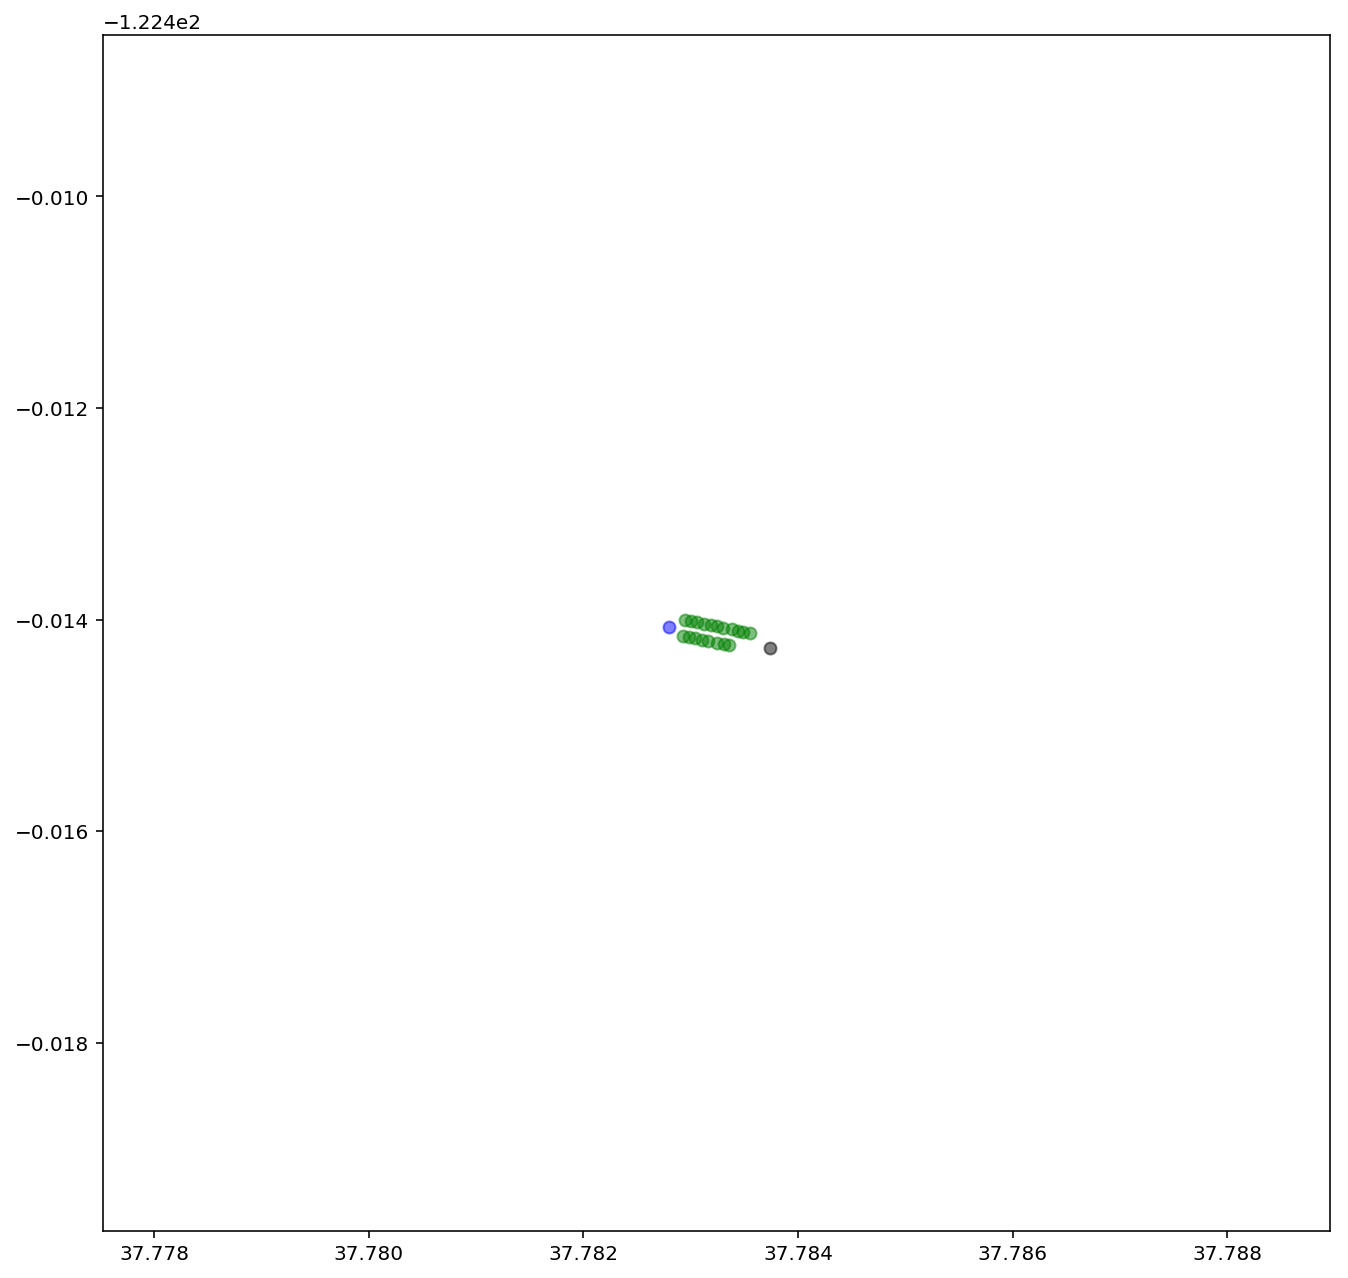

In [52]:
section_number = 26
print(train_df.loc[train_df['STR_SEC']==section_number, ['Street', 'From', 'To']])
latF, lonF = plot_unique_coords(train_df[train_df['STR_SEC']==section_number], 'From_lat', 'From_long')
latT, lonT = plot_unique_coords(train_df[train_df['STR_SEC']==section_number], 'To_lat', 'To_long')
latp, lonp = plot_unique_coords(parking_df[parking_df['STR_SEC']==section_number], 'lat', 'lon')

plt.figure(figsize=(11,11))
plt.scatter(latp, lonp, c='g', alpha = 0.5)
plt.scatter(latF, lonF, c='b', alpha=0.5)
plt.scatter(latT, lonT, c='black', alpha = 0.5)

In [102]:
train_df[train_df['Street'] == 'Jones Street' ]

,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,holiday,day,...,f_pop,house_avg_value,house_pct,m_pop,med_age,pop,twn_avg_value,twn_pct,STREET,STR_SEC
214,Jones Street,Ellis Street,Eddy Street,2014-02-03,13:56,8,104.767970,1,0,3,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,32
272,Jones Street,Bush Street,Sutter Street,2014-02-03,13:44,2,105.073950,1,0,3,...,31.8,NaN,NaN,39.2,31.8,47.0,NaN,NaN,JONES STREET,61
273,Jones Street,Sutter Street,Jones Street,2014-02-03,13:44,2,72.917170,1,0,3,...,48.0,NaN,NaN,45.3,48.0,9085.0,NaN,NaN,JONES STREET,54
274,Jones Street,Post Street,Colin Place,2014-02-03,13:44,0,32.078580,0,0,3,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,48
275,Jones Street,Colin Place,Geary Street,2014-02-03,13:44,5,72.545090,1,0,3,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,47
276,Jones Street,Antonio Street,Ellis Street,2014-02-03,13:56,7,51.088688,1,0,3,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,34
465,Jones Street,Ellis Street,Eddy Street,2014-02-16,12:50,0,104.767970,0,0,16,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,32
518,Jones Street,Ellis Street,Eddy Street,2014-02-25,11:18,0,104.767970,0,0,25,...,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN,JONES STREET,32
529,Jones Street,Bush Street,Sutter Street,2014-02-25,11:17,0,105.073950,0,0,25,...,31.8,NaN,NaN,39.2,31.8,47.0,NaN,NaN,JONES STREET,61
530,Jones Street,Sutter Street,Jones Street,2014-02-25,11:17,0,72.917170,0,0,25,...,48.0,NaN,NaN,45.3,48.0,9085.0,NaN,NaN,JONES STREET,54
